# Тестовое задание
Патшин Антон

<<
Файл test.csv содержит синтетические временные ряды. Каждая строка описывает состояние рынка в фиксированный момент времени (строки записаны в хронологическом порядке).

Сигналы {x1, ..., x8, y1} -- цены некоторых финансовых инструментов. Сигналы {s1, s2} -- вспомогательные сигналы. Модель ценообразования инструмента y1 скрыта. Известно, что значение y1[t] зависит от истории {x1, ..., x8}, а также s1 и s2.

I.

1. Построить предиктивную модель на сигнал y1 (в каждый момент времени t уметь предсказывать значение сигнала y1[t+1]).
2. Оценить качество полученной модели.
3. Сравнить с моделью, prediction(y1)[t+1] = y1[t], то есть с моделью, которая предсказывает "то же самое значение что и сейчас".

II.

В каждый момент времени можно купить (продать) не более одного лота по инструменту y1. Комиссия за каждую сделку составляет 0.1%.

1. Используя модель из пункта I, написать робота, торгующего на инструменте y1.
2. Оценить полученные результаты.

Язык программирования Python или R. В качестве решения приложить краткое описание модели\робота и результат (с подходящими графиками).>>




# I:
Идеи/план/фичи
* 1 модель: $y_{n+1}=f(y_n)$
* 2 модель: $y_{n+1}=y_{n}$
* 3 модель: $y_{n+1}=f(x1_n,...,x8_n,s1_n,s2_n,y_n)$
* 4 модель: $y_{n+1}=f(x1_{n-k},...,x1_{n-1},x1_{n},x2_{n-k},...,s2_{n},y_{n-k},...,y_n)$
* n+1 модель: n модель + сезонные явления (upd: доиследовать)
* обработать сигналы s1 и s2
* что-нибудь ещё


* Т.к. данных достаточно -- **отложим 10%**, для теста.
* процедурf кросс-валидации: **TimeSeriesSplit**, т.к. у нас времяные ряды, то нам нужно, что бы при валидации, модель не подсматривала будущее и не пыталсь предсказать уже известное будущее, по этому будем использовать кросс-валидацию, которая делит датасет на части, постепенно наращивая размер. Будем использовать разбиение на "5" и на "10". Картинка для наглядности:
* функция ошибки: минимизируем sqrt(mean_squared_error)

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png'>

* начнём с LinearRegression, Lasso (LassoCV), Ridge (RidgeCV)

upd:
* "4 модель", показала наилучший результат
* подобрали параметры лагов
* Lasso (LassoCV) - ничего не получилось
* LinearRegression "завтра так же, как и сегодня":
        0.040089
* LinearRegression top:
        0.022386
* Ridge (RidgeCV):
        0.022392

Получилось добиться уменьшения не верного предсказания в **x1,79** раза, по сравнению с моделью "завтра так же, как и сегодня"


upd2: слишком мнеого времени ушло на доводку (на эти тысячные и десятитысячные доли) -_-
 лучше бы ко второй части приступил
# II:
Идеи/план/фичи
* написать функцию подсчёта выигрыша (спросить: "В каждый момент времени можно купить (продать) не более одного лота по инструменту y1." -- начит ли это, что мы, если уже купили, но ещё не продали, то можем ещё покупать? )
* сделать простой классификатор на логРегрессии
* посмотреть в сторону обучения с подкреплением
* нейроночки?
* GANы?


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
%matplotlib inline
from scipy import signal, stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from itertools import product


In [2]:
df = pd.read_csv('test_junior/test.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
x1    200000 non-null float64
x2    200000 non-null float64
x3    200000 non-null float64
x4    200000 non-null float64
x5    200000 non-null float64
x6    200000 non-null float64
x7    200000 non-null float64
x8    200000 non-null float64
s1    200000 non-null float64
s2    200000 non-null float64
y1    200000 non-null float64
dtypes: float64(11)
memory usage: 16.8 MB


In [4]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,s1,s2,y1
0,996.7459,1001.2642,999.1467,997.4923,999.7231,1000.8404,999.3012,998.4121,0.0,1.0,995.2712
1,996.6976,1001.2588,999.1436,997.5075,999.7024,1000.8533,999.3144,998.4018,0.0,1.0,995.2380
2,996.6631,1001.2644,999.1461,997.4998,999.7481,1000.8321,999.3057,998.4034,0.0,1.0,995.2146
3,996.6342,1001.2723,999.1480,997.5134,999.7333,1000.8421,999.2866,998.4075,0.0,1.0,995.1892
4,996.6195,1001.2735,999.1411,997.5150,999.7638,1000.8392,999.2458,998.4168,0.0,1.0,995.1890


In [5]:
df[['s1','s2']] = df[['s1','s2']].astype('int64')

In [6]:
df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,s1,s2,y1
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1008.134596,1025.035793,999.260620,964.639790,1003.458776,1002.337918,991.419426,1007.265458,0.497585,0.492635,1000.569767
std,8.320269,13.284707,1.921541,14.535008,2.514194,2.332001,9.285440,3.795613,0.499995,0.499947,10.439449
min,992.325100,1000.095400,995.640500,935.809200,998.046500,997.274500,976.773000,997.779700,0.000000,0.000000,975.995900
25%,1001.973275,1012.776175,997.687875,951.858475,1001.579300,1000.541000,980.413575,1004.832975,0.000000,0.000000,994.712300
50%,1007.351750,1024.276650,999.243850,968.318800,1003.627300,1001.957700,992.325800,1007.234150,0.000000,0.000000,999.606550
75%,1012.614700,1036.769225,1000.311500,975.125825,1004.709700,1003.962500,1000.038000,1009.798825,1.000000,1.000000,1004.962125
max,1033.171200,1049.480900,1006.029700,1003.998000,1010.225800,1008.950700,1005.285200,1015.323100,1.000000,1.000000,1026.447300


In [7]:
df['s1'].value_counts()

0    100483
1     99517
Name: s1, dtype: int64

In [8]:
df['s2'].value_counts()

0    101473
1     98527
Name: s2, dtype: int64

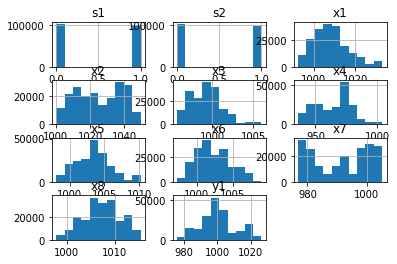

In [9]:
df.hist();

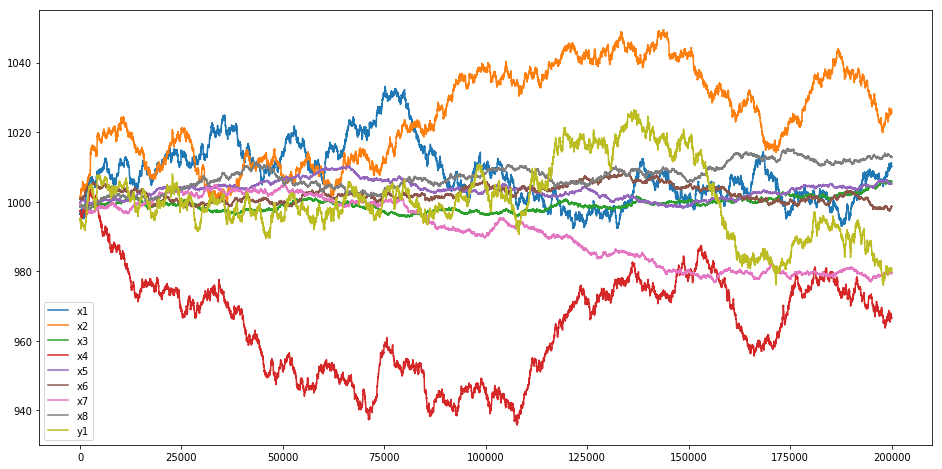

In [10]:
df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y1']].plot(figsize=(16,8));

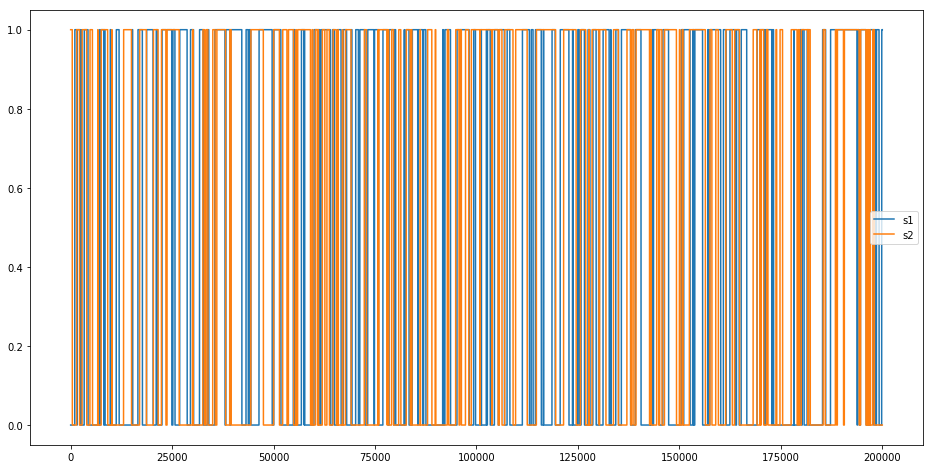

In [11]:
df[['s1','s2']].plot(figsize=(16,8));

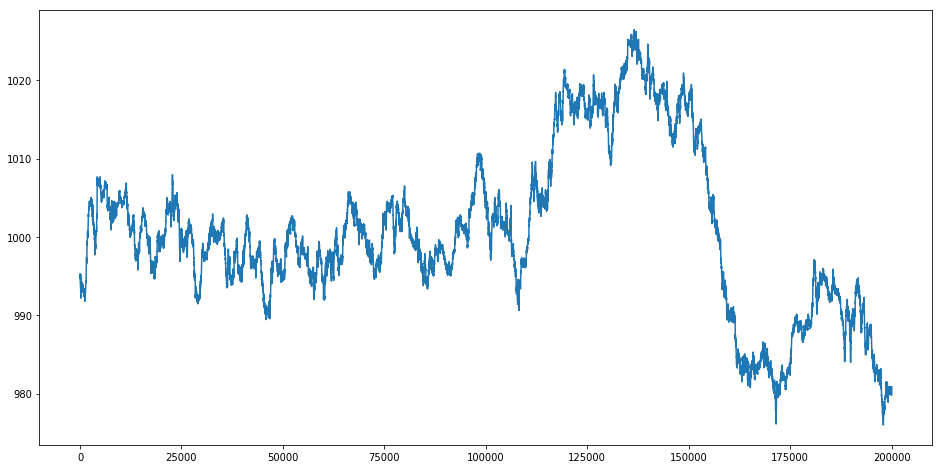

In [12]:
df['y1'].plot(figsize=(16,8));

In [13]:
df.corr()

,x1,x2,x3,x4,x5,x6,x7,x8,s1,s2,y1
x1,1.000000,-0.664239,-0.364609,-0.371712,0.524595,-0.422059,0.633627,-0.360258,0.056007,-0.097826,-0.142997
x2,-0.664239,1.000000,0.122677,0.143268,-0.543736,0.665022,-0.723773,0.404080,-0.030180,0.140702,0.485245
x3,-0.364609,0.122677,1.000000,0.409434,-0.041529,-0.223196,-0.548940,0.362792,-0.002134,-0.003410,-0.350626
x4,-0.371712,0.143268,0.409434,1.000000,-0.595339,0.188774,-0.310001,-0.071551,-0.033371,-0.000719,0.215093
x5,0.524595,-0.543736,-0.041529,-0.595339,1.000000,-0.511530,0.480683,-0.084129,0.047359,-0.047073,-0.392478
x6,-0.422059,0.665022,-0.223196,0.188774,-0.511530,1.000000,-0.257544,-0.145148,-0.062725,0.167127,0.780524
x7,0.633627,-0.723773,-0.548940,-0.310001,0.480683,-0.257544,1.000000,-0.694306,-0.003926,-0.046594,0.037063
x8,-0.360258,0.404080,0.362792,-0.071551,-0.084129,-0.145148,-0.694306,1.000000,0.057286,0.026024,-0.382098
s1,0.056007,-0.030180,-0.002134,-0.033371,0.047359,-0.062725,-0.003926,0.057286,1.000000,-0.007052,-0.053531
s2,-0.097826,0.140702,-0.003410,-0.000719,-0.047073,0.167127,-0.046594,0.026024,-0.007052,1.000000,0.115611


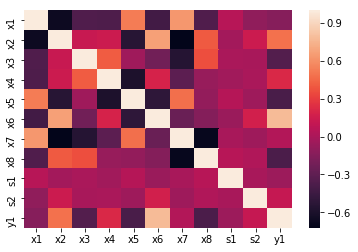

In [14]:
sns.heatmap(df.corr())

In [15]:
time_series_col = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y1'] 
flag00 = ((df['s1'] == 0) & (df['s2'] == 0))
flag01 = ((df['s1'] == 0) & (df['s2'] == 1))
flag10 = ((df['s1'] == 1) & (df['s2'] == 0))
flag11 = ((df['s1'] == 1) & (df['s2'] == 1))


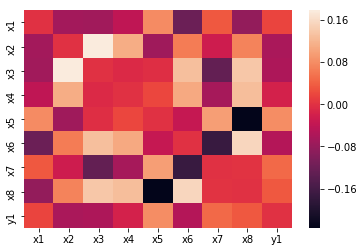

In [16]:
sns.heatmap(df[(df['s1'] == 1)][time_series_col].corr() - df[(df['s1'] == 0)][time_series_col].corr());

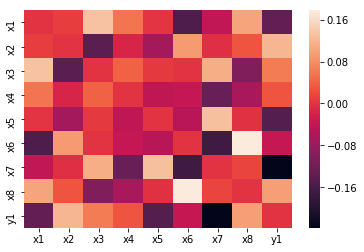

In [17]:
sns.heatmap(df[(df['s2'] == 1)][time_series_col].corr() - df[(df['s2'] == 0)][time_series_col].corr());

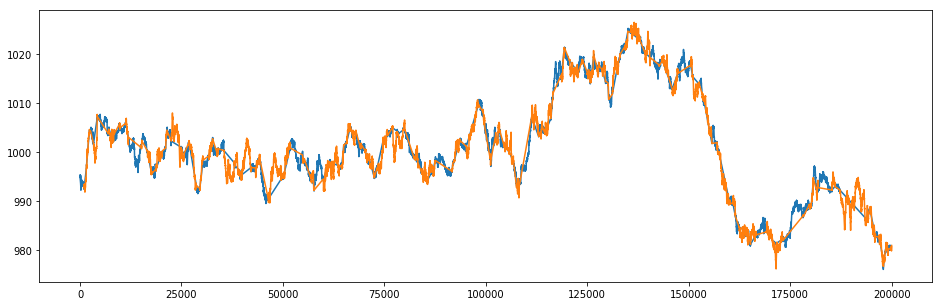

In [18]:
def signalperiodogram(df_time_series, begin_ = 0, end_=60, p_ = 0.95, marker_ = 'x--', scaling_='spectrum'):
    fig1 = plt.figure(figsize=(12,30))
    shape_ = df_time_series.shape[1]
    for i in np.arange(df_time_series.shape[1]):

        ax1 = fig1.add_subplot(6*shape_,1,1+i)
        ax1.plot(f[begin_: end_], np.sqrt(Pxx_spec[begin_: end_]),marker_)
        ax1.plot(f[begin_: end_],[D_signal for _ in f[begin_: end_]],'-',color = 'orange')
        ax1.set_ylabel('Linear spectrum [V RMS]\n %s' % df_time_series.columns[i])
        
        ax1.grid()



df[(df['s1'] == 0)]['y1'].plot(figsize=(16,5)),
df[(df['s1'] == 1)]['y1'].plot(figsize=(16,5))

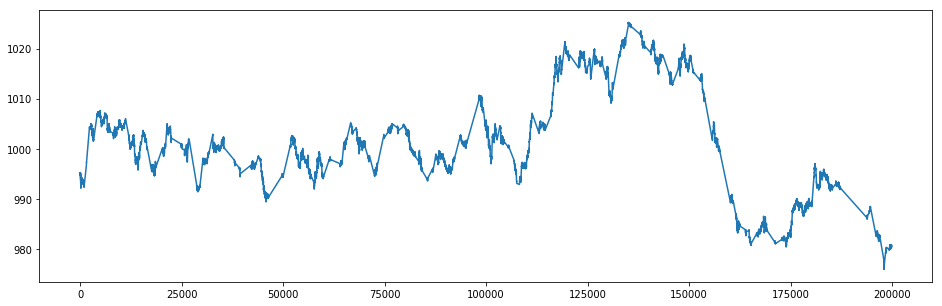

In [19]:
df[(df['s1'] == 0)]['y1'].plot(figsize=(16,5));

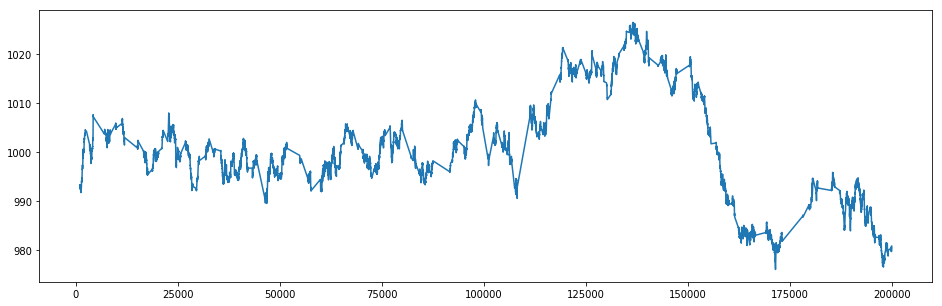

In [20]:
df[(df['s1'] == 1)]['y1'].plot(figsize=(16,5));

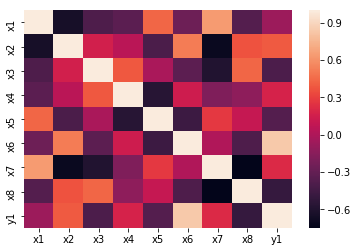

In [21]:
sns.heatmap(df[flag00][time_series_col].corr());

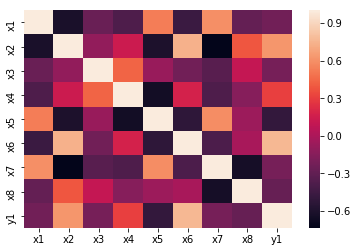

In [22]:
sns.heatmap(df[flag01][time_series_col].corr());

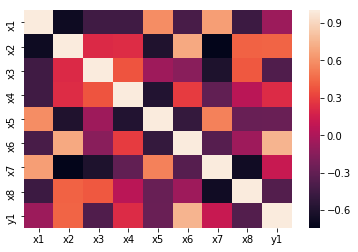

In [23]:
sns.heatmap(df[flag10][time_series_col].corr());

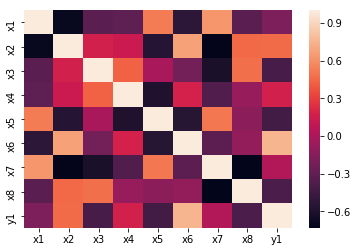

In [24]:
sns.heatmap(df[flag11][time_series_col].corr());

In [25]:
def signalperiodogram(df_time_series, begin_ = 0, end_=60, p_ = 0.95, marker_ = 'x--', scaling_='spectrum'):
    fig1 = plt.figure(figsize=(12,30))
    shape_ = df_time_series.shape[1]
    for i in np.arange(df_time_series.shape[1]):

        f, Pxx_spec = signal.periodogram(df_time_series[df_time_series.columns[i]] - df_time_series[df_time_series.columns[i]].mean(), window= 'flattop', scaling=scaling_)
        q_ = 1 - p_
        X1_ = -np.log(1-np.power(1 - q_, 2/(df_time_series.shape[0] - 2)))
        D_signal = np.var(df_time_series[df_time_series.columns[i]])**2/df_time_series.shape[0]*X1_
        
        ax1 = fig1.add_subplot(shape_,1,1+i)
        ax1.plot(f[begin_: end_], np.sqrt(Pxx_spec[begin_: end_]),marker_)
        ax1.plot(f[begin_: end_],[D_signal for _ in f[begin_: end_]],'-',color = 'orange')
        ax1.set_ylabel('Linear spectrum [V RMS]\n %s' % df_time_series.columns[i])
        
        ax1.grid()

        if (i == 0):
            ax1.set_title('periodogram')
        if ((1+i) == shape_):
            ax1.set_xlabel('frequency [Hz]')

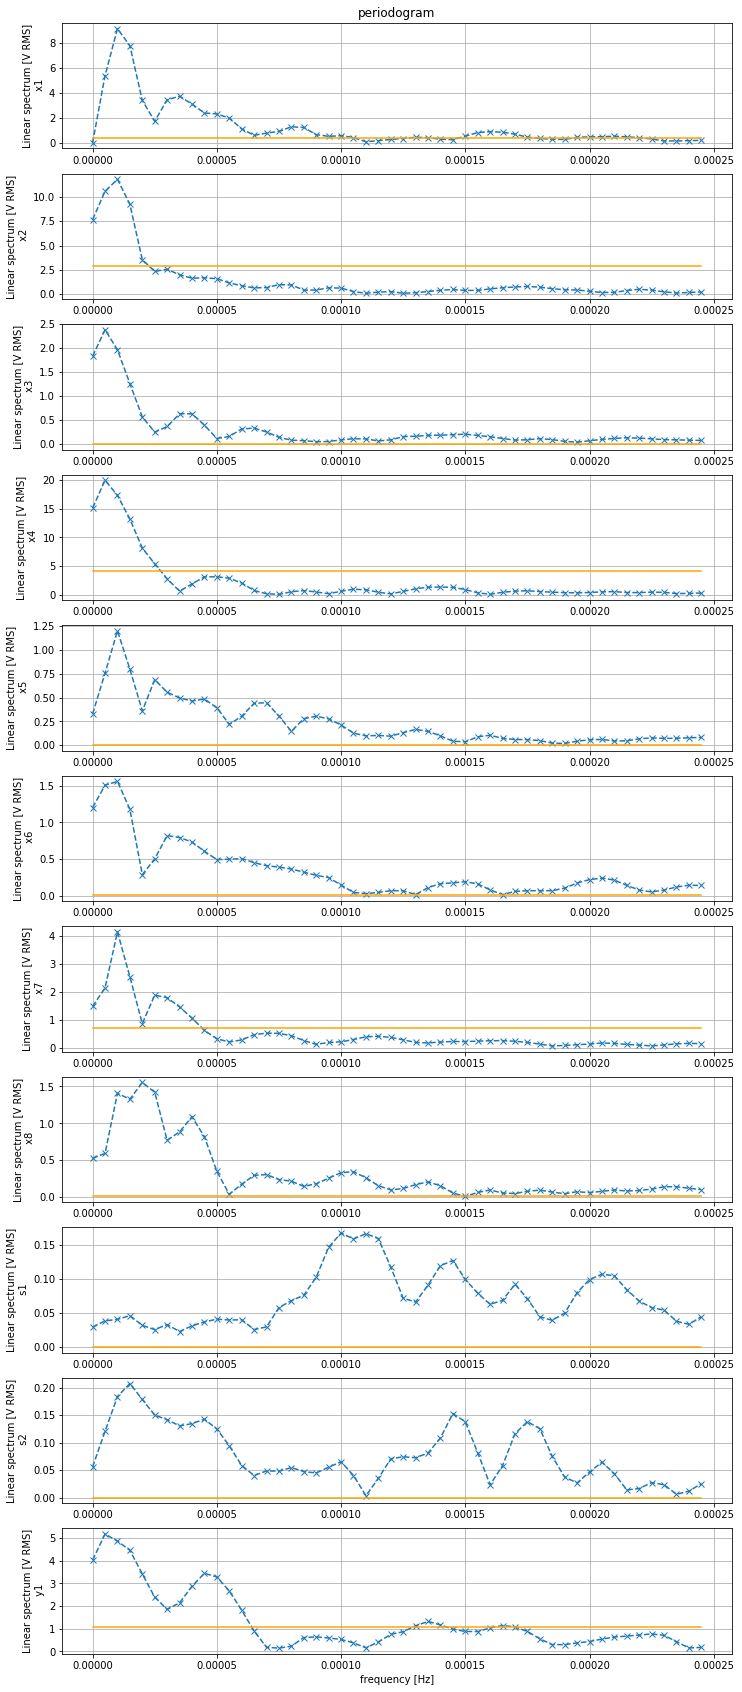

In [26]:
signalperiodogram(df, 0, 50, 0.999,'x--')

In [27]:
import numpy as np
rand = np.random.RandomState(42)
t = 100 * rand.rand(100)
y = np.sin(2 * np.pi * t) + 0.1 * rand.randn(100) + 10
#plt.plot(t,y)
#plt.plot(df['y1'].index, df['y1'])

In [28]:
from astropy.stats import LombScargle
#frequency, power = LombScargle(t, y).autopower()
frequency, power = LombScargle(df['y1'].index, df['y1']).autopower()

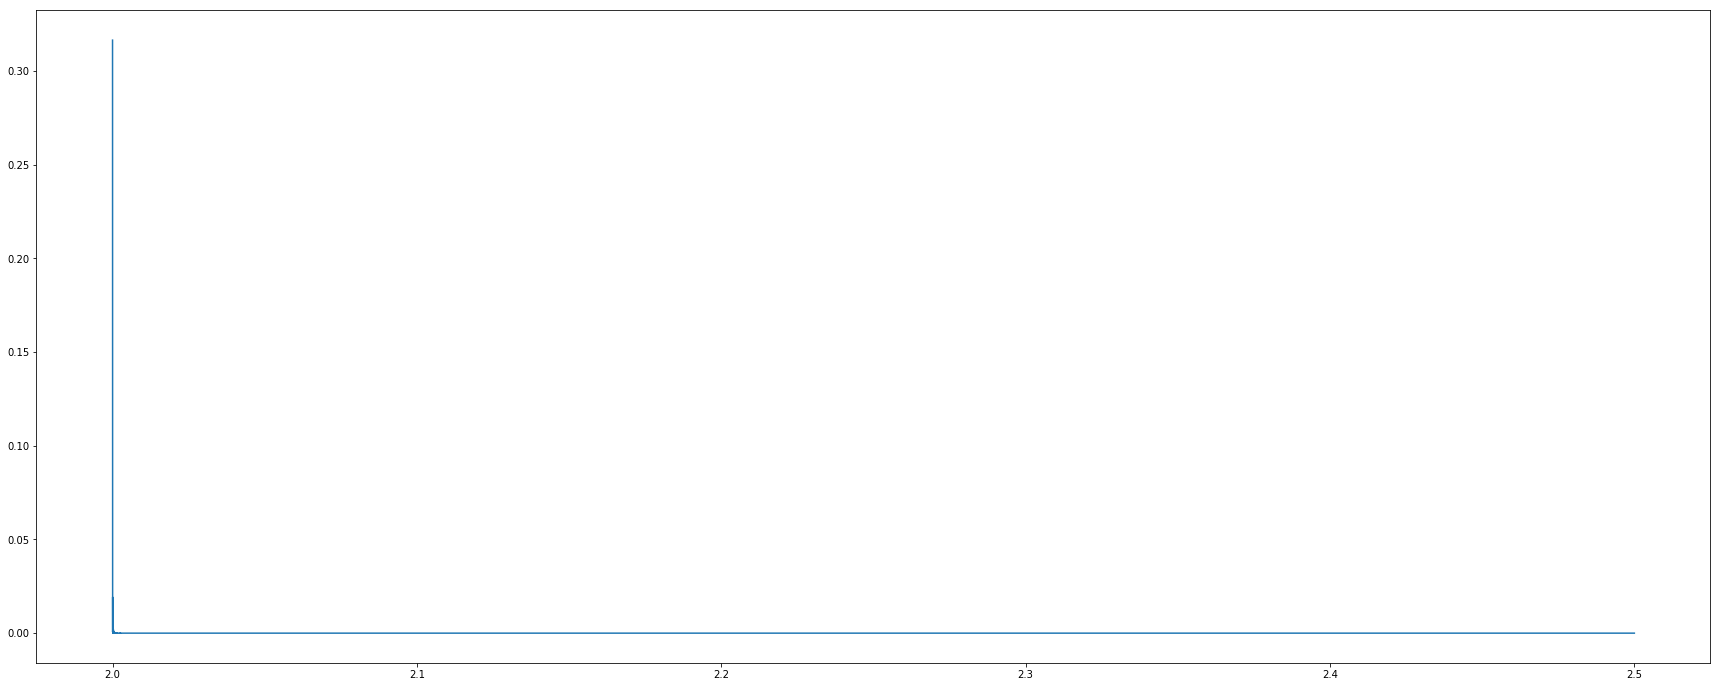

In [29]:
plt.figure(figsize=(30,12))
plt.plot(frequency[2000000:], power[2000000:])       

In [30]:
max(power),min(power)

(0.50081481353162383, -0.077354108764762161)

In [31]:
def corr_ts(df_):
    corr = signal.correlate(df_-df_.mean(), df_-df_.mean())/df_.shape[0]
    plt.figure(figsize=(30,12))
    plt.plot(corr[:int(len(corr)/2)])

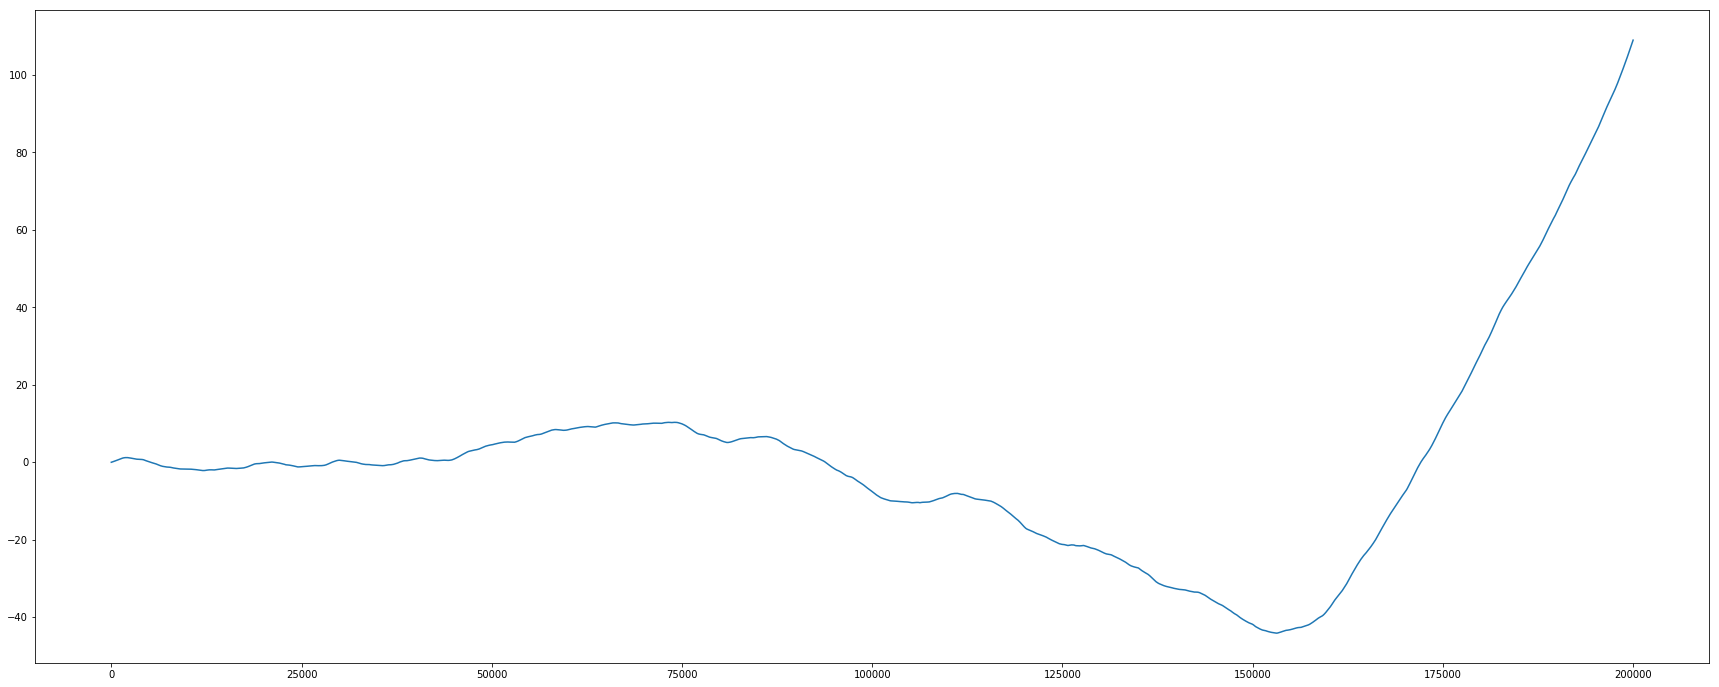

In [32]:
corr_ts(df['y1'])

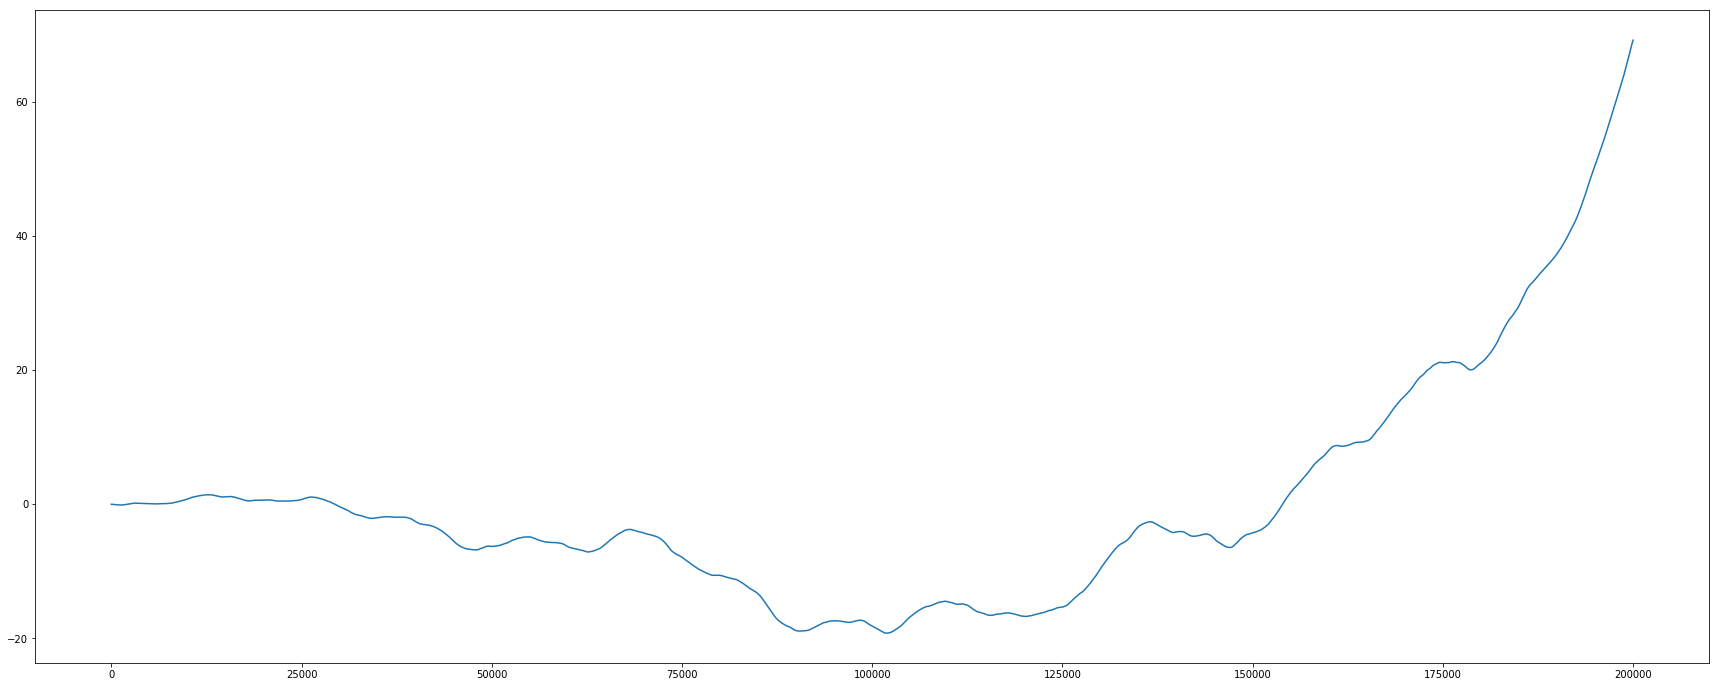

In [33]:
corr_ts(df['x1'])

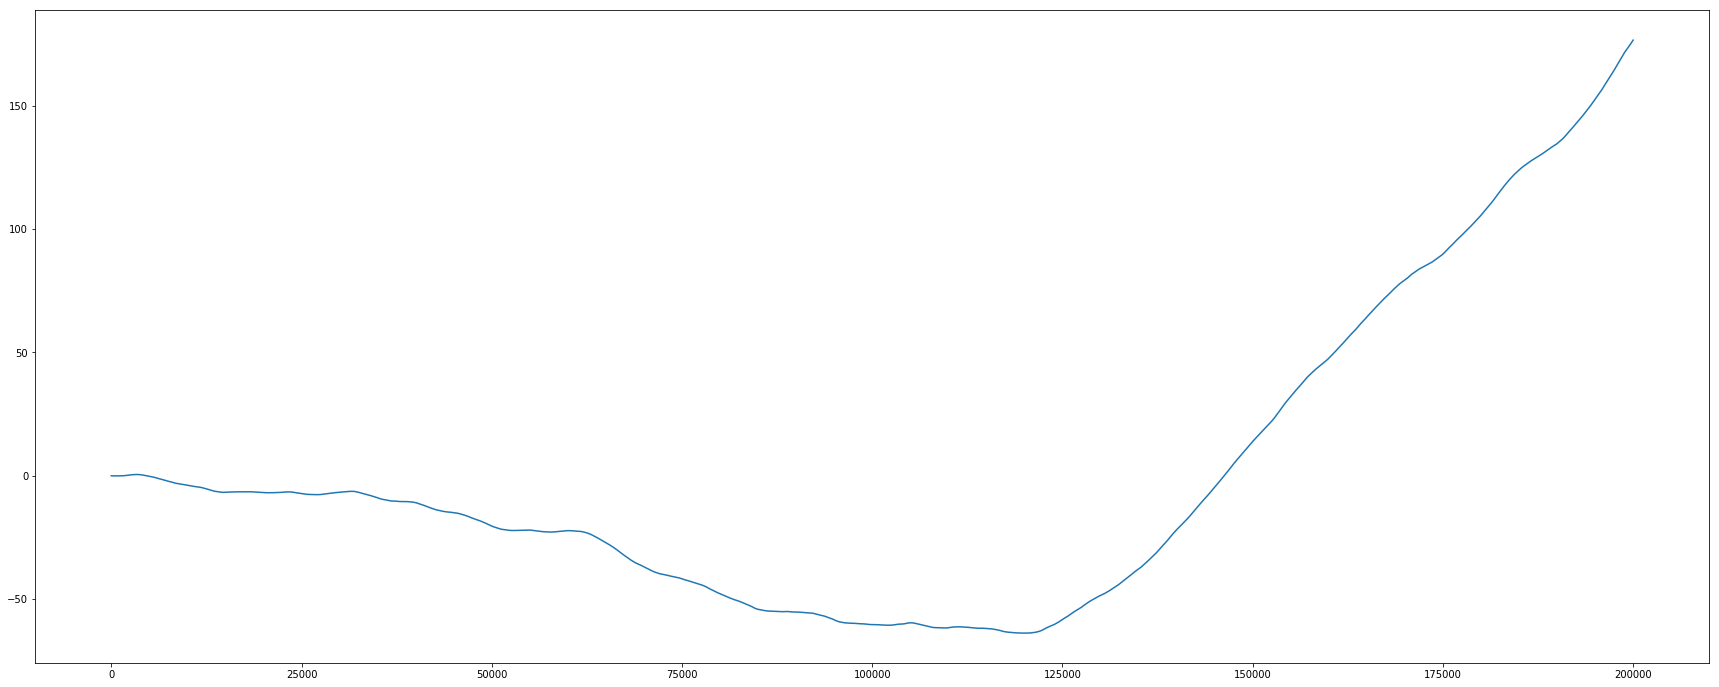

In [34]:
corr_ts(df['x2'])

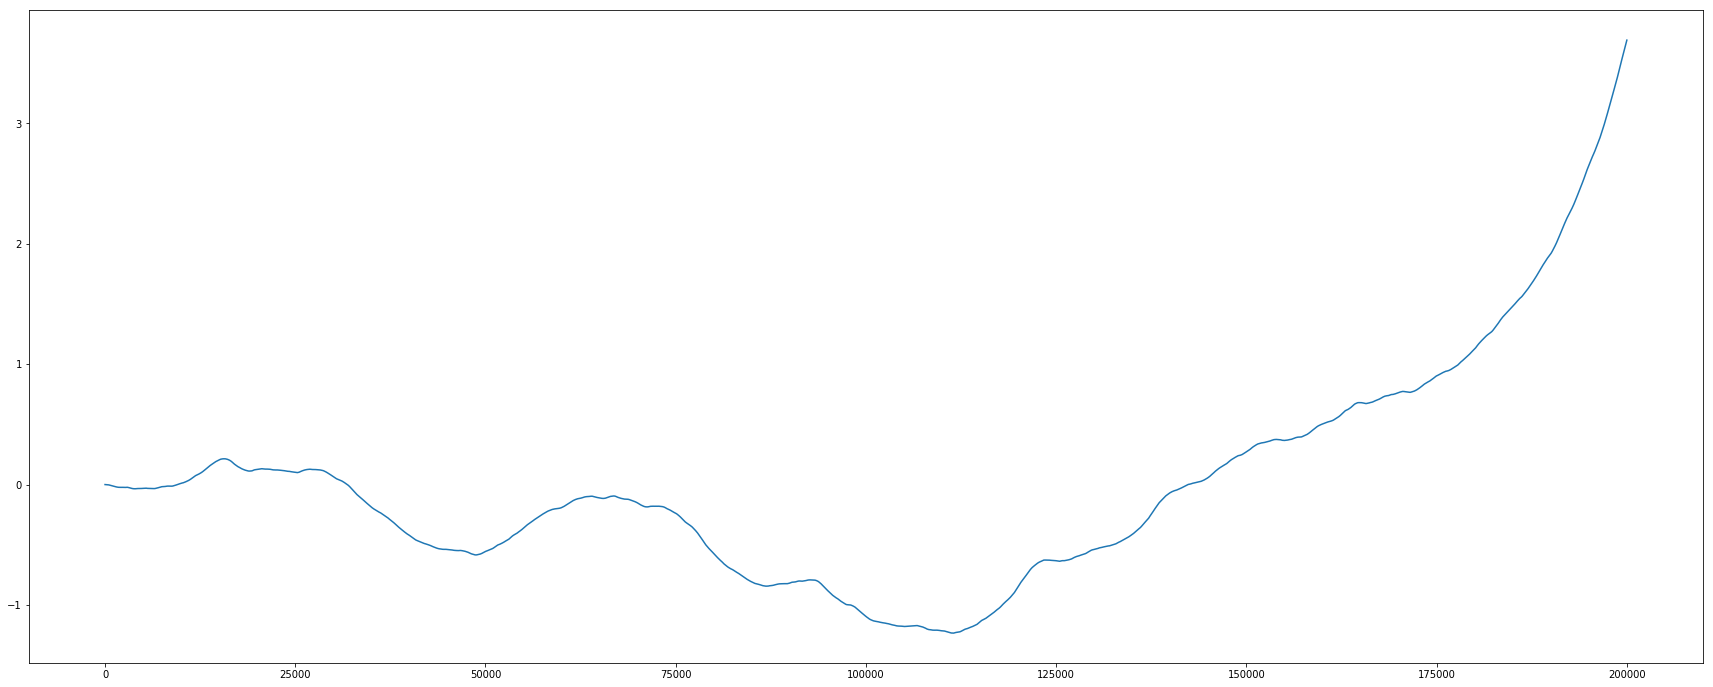

In [35]:
corr_ts(df['x3'])

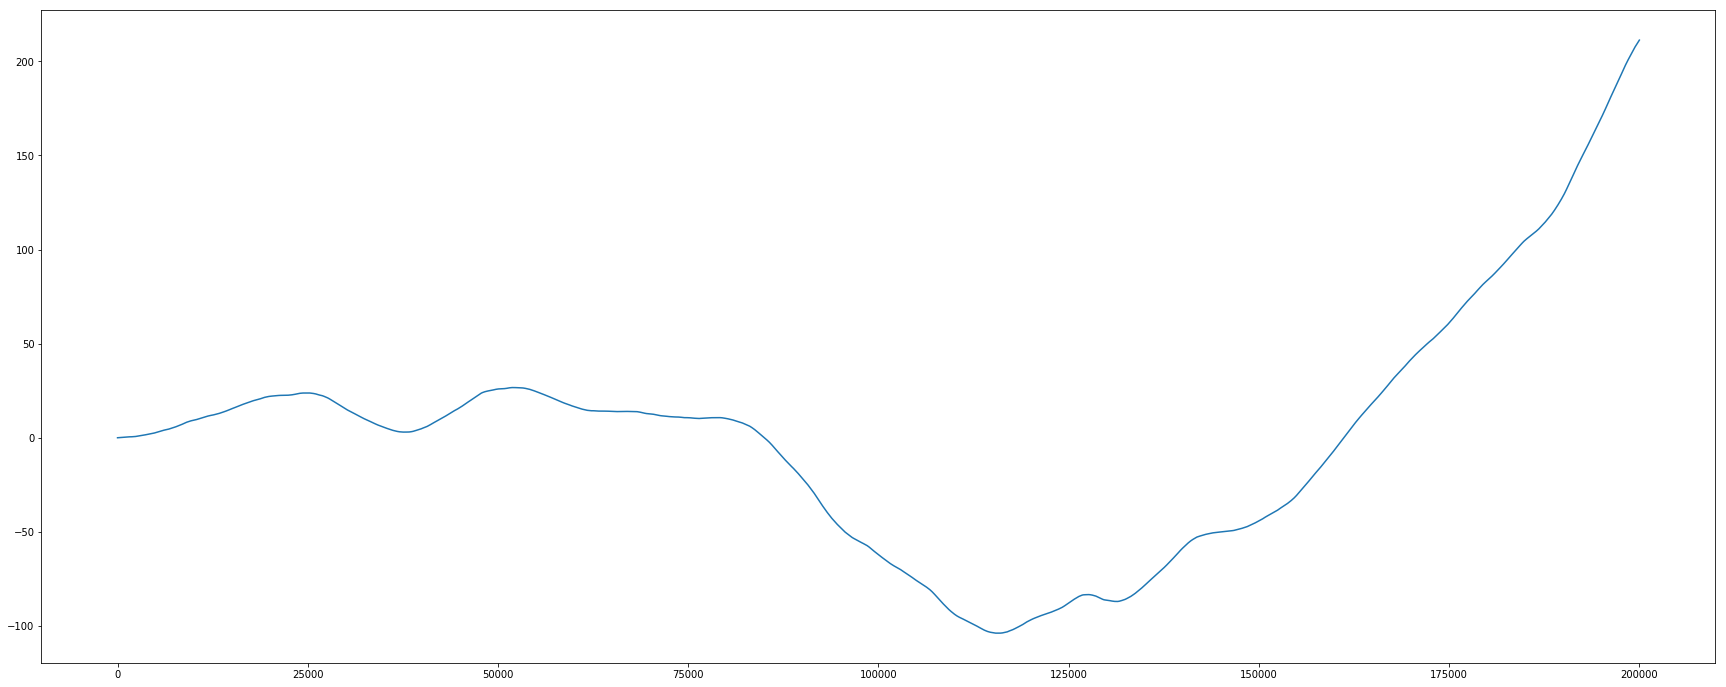

In [36]:
corr_ts(df['x4'])


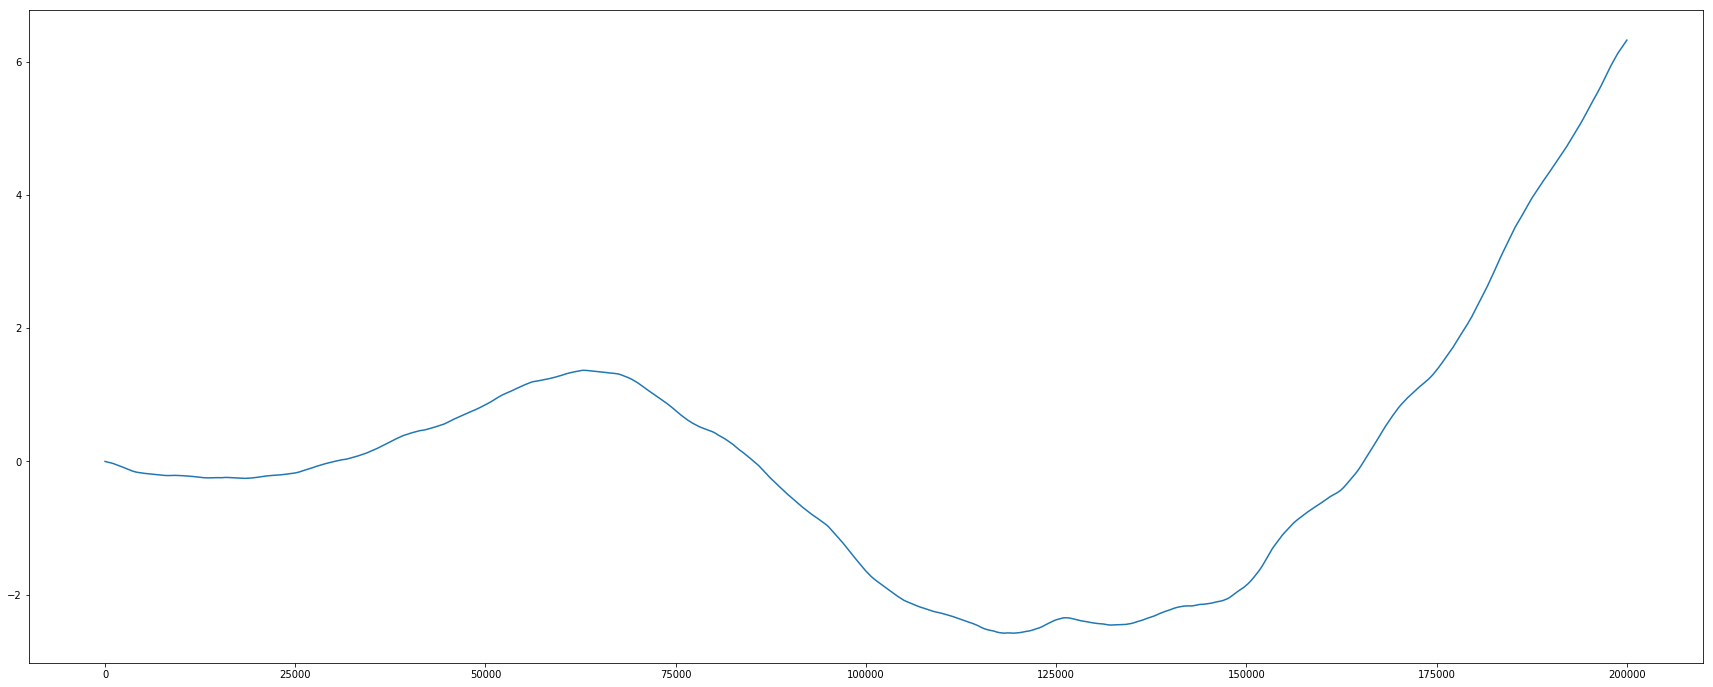

In [37]:
corr_ts(df['x5'])

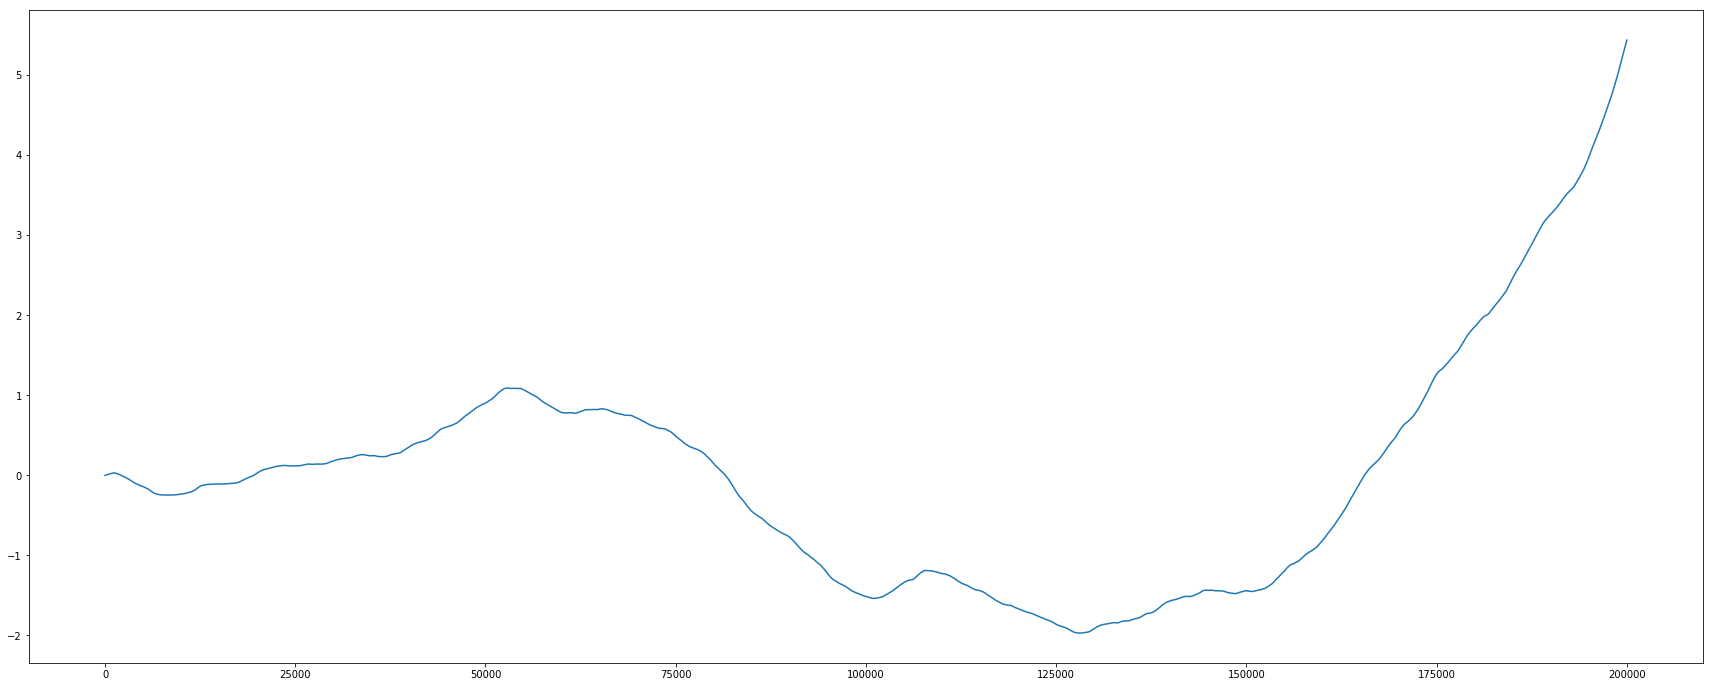

In [38]:
corr_ts(df['x6'])

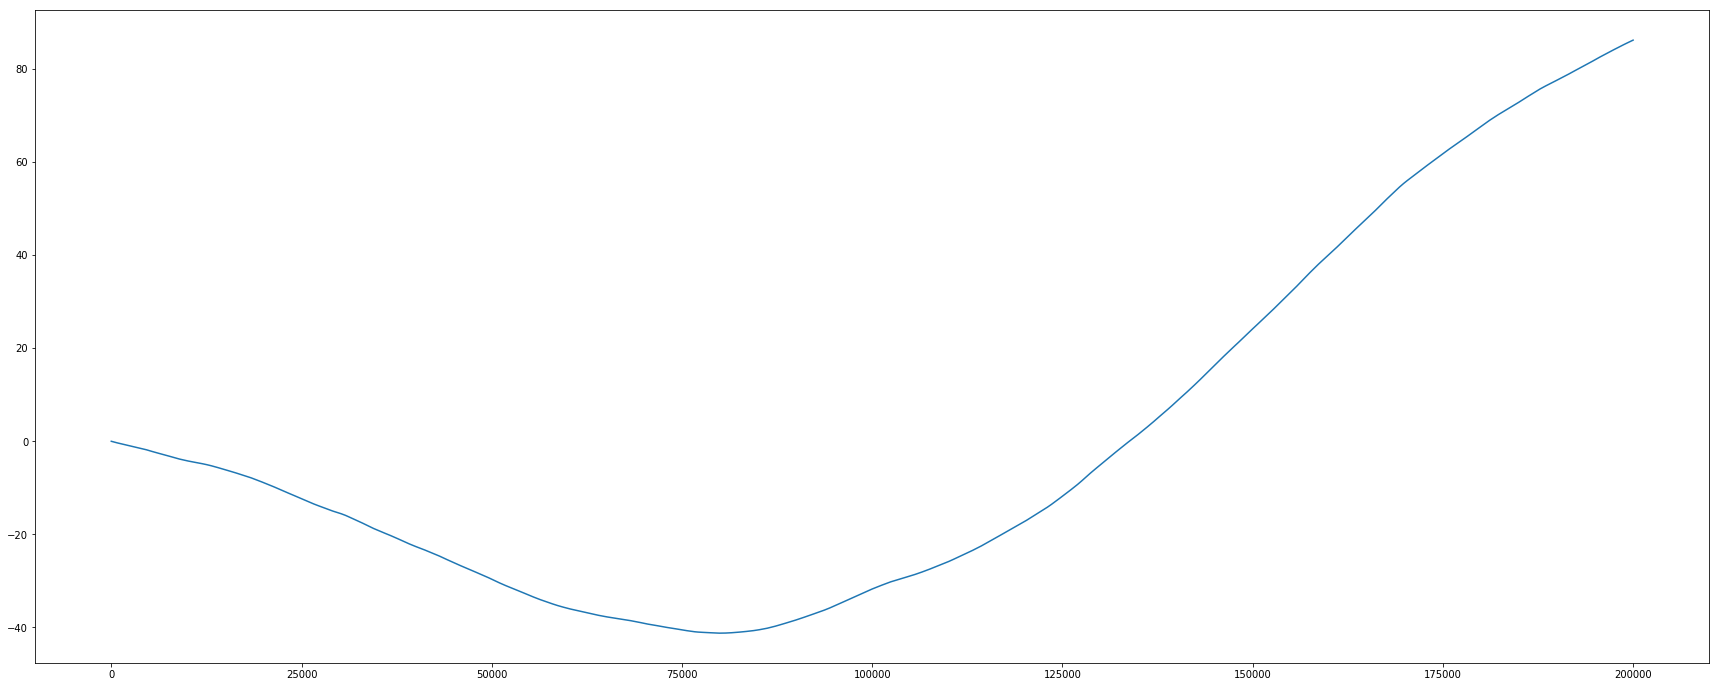

In [39]:
corr_ts(df['x7'])

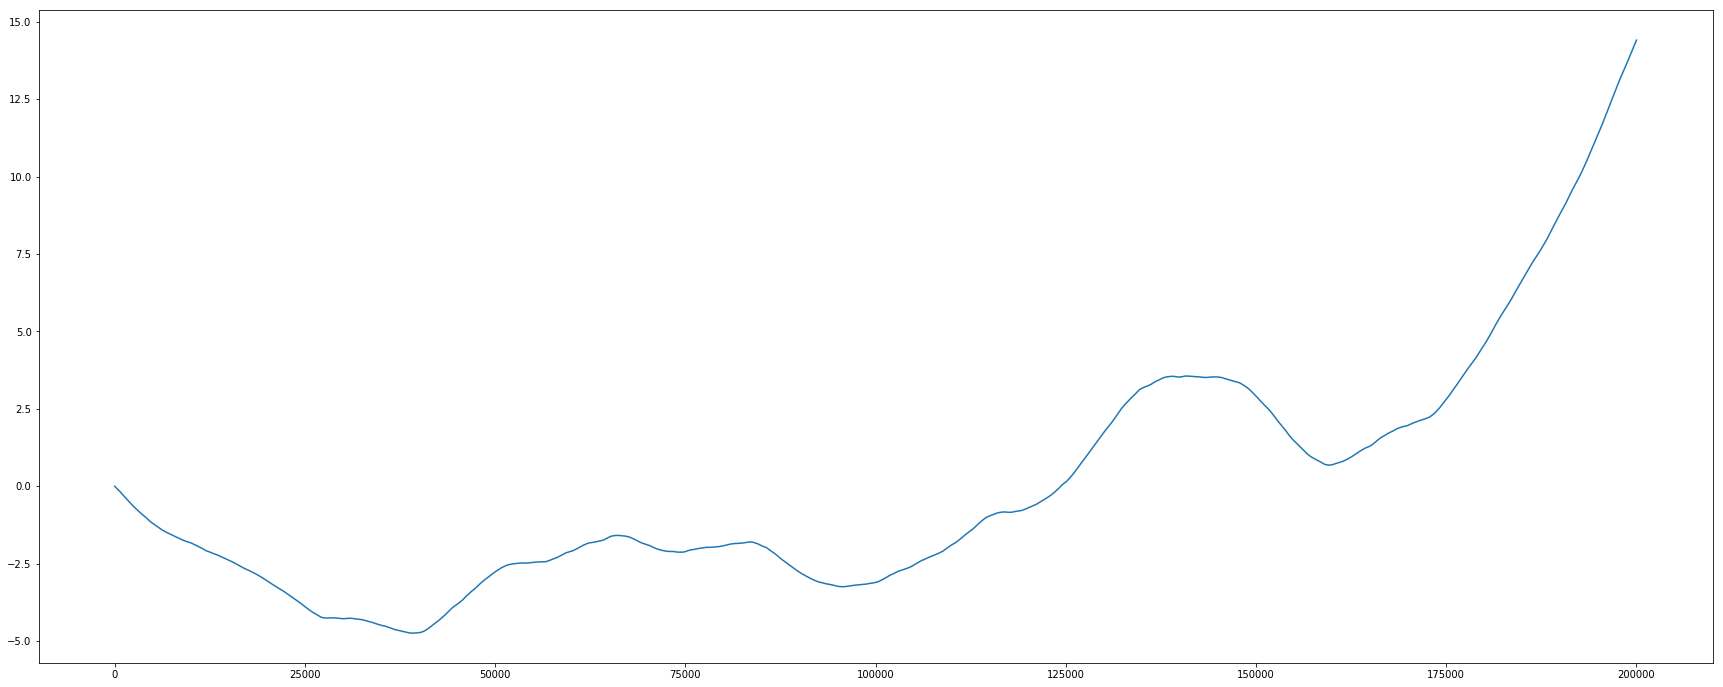

In [40]:
corr_ts(df['x8'])

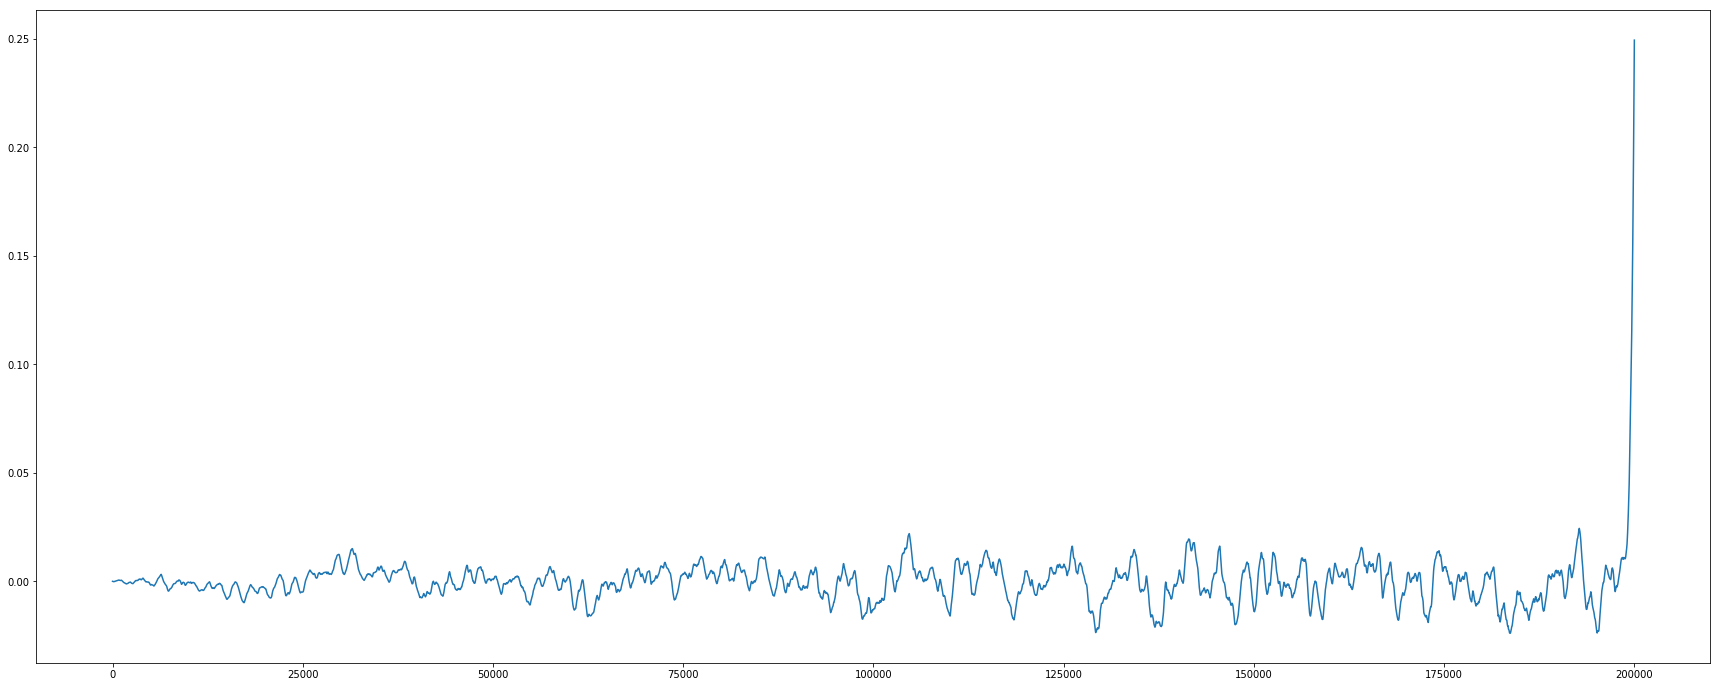

In [41]:
corr_ts(df['s1'])

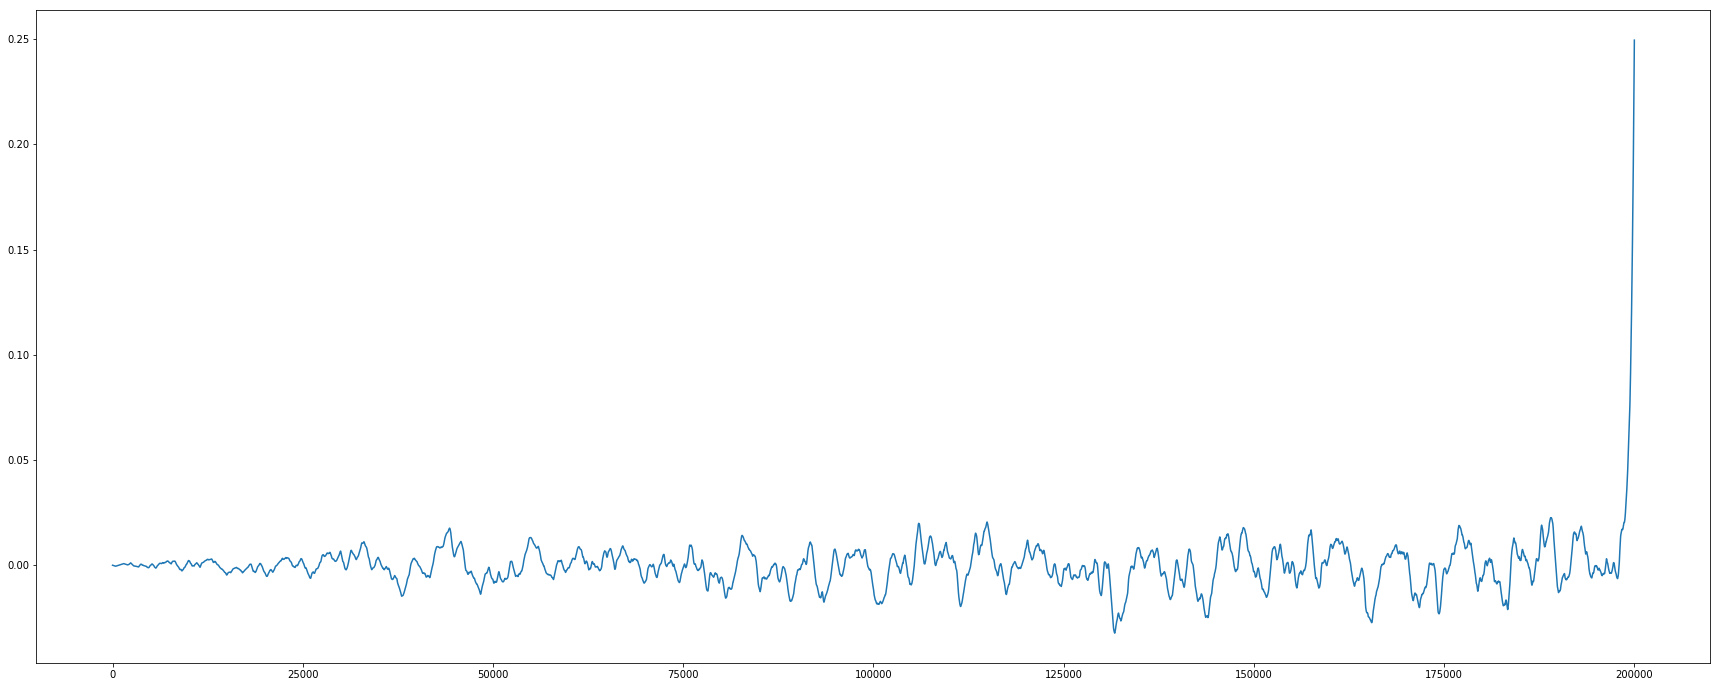

In [42]:
corr_ts(df['s2'])

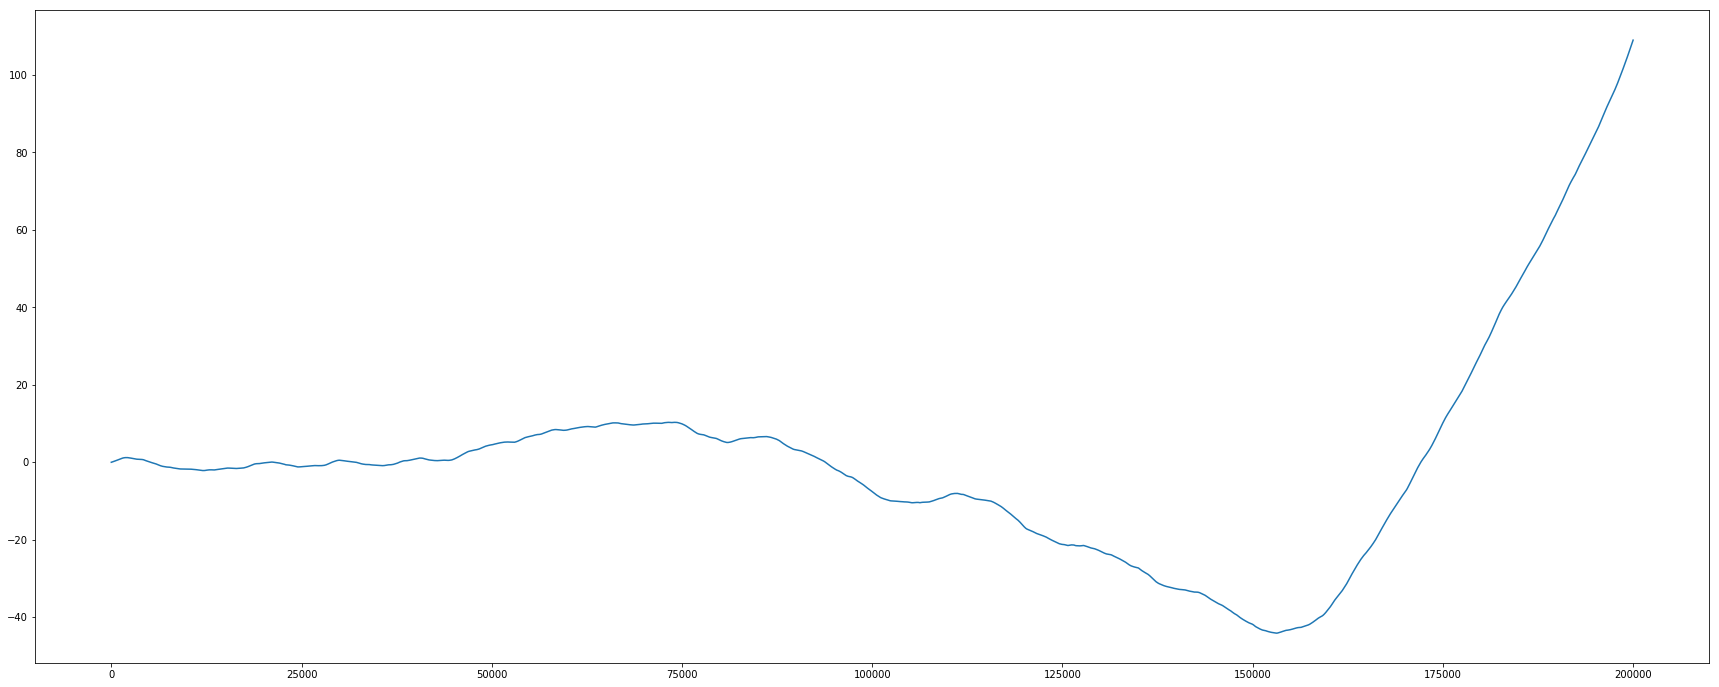

In [43]:
corr_ts(df['y1'])

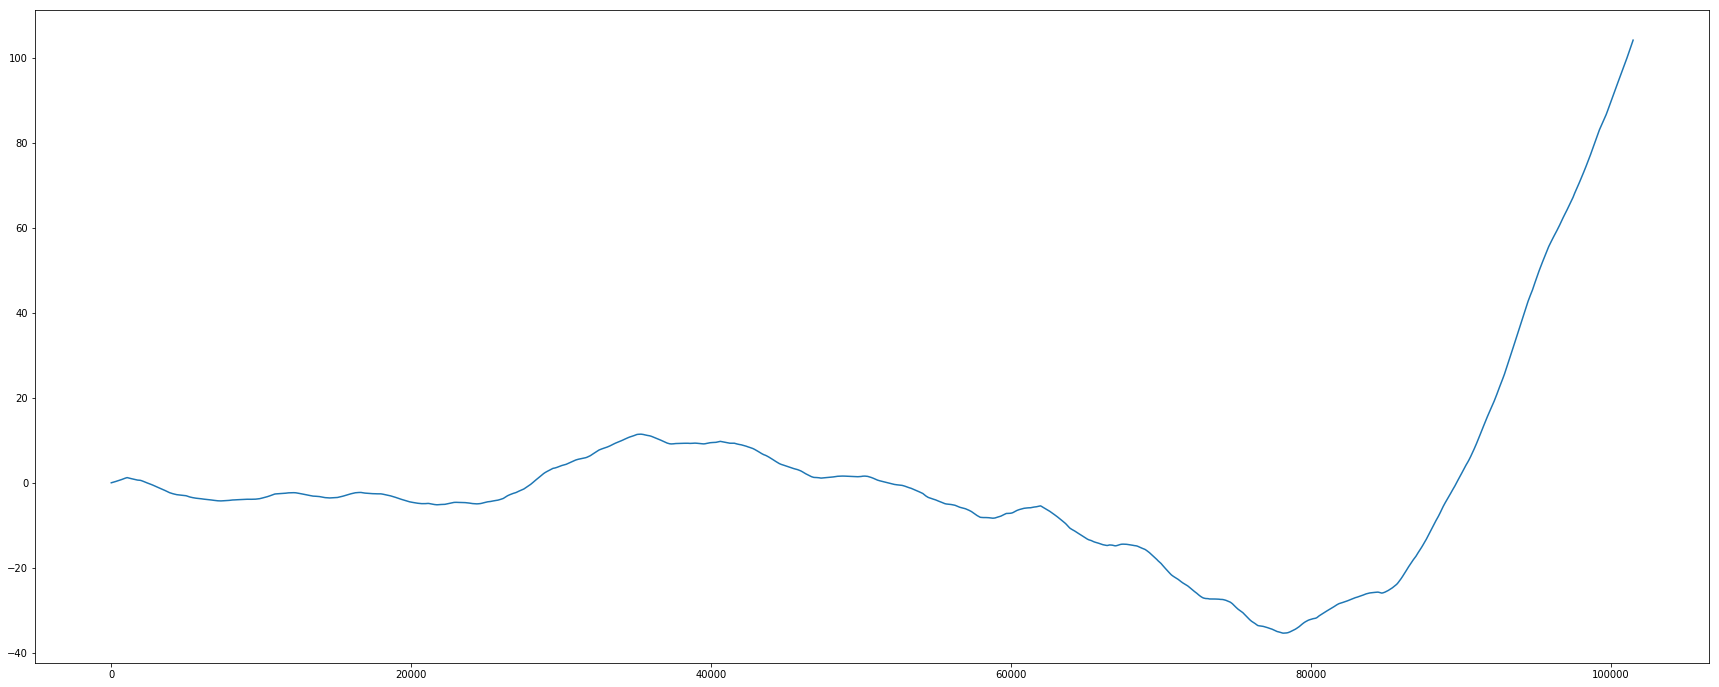

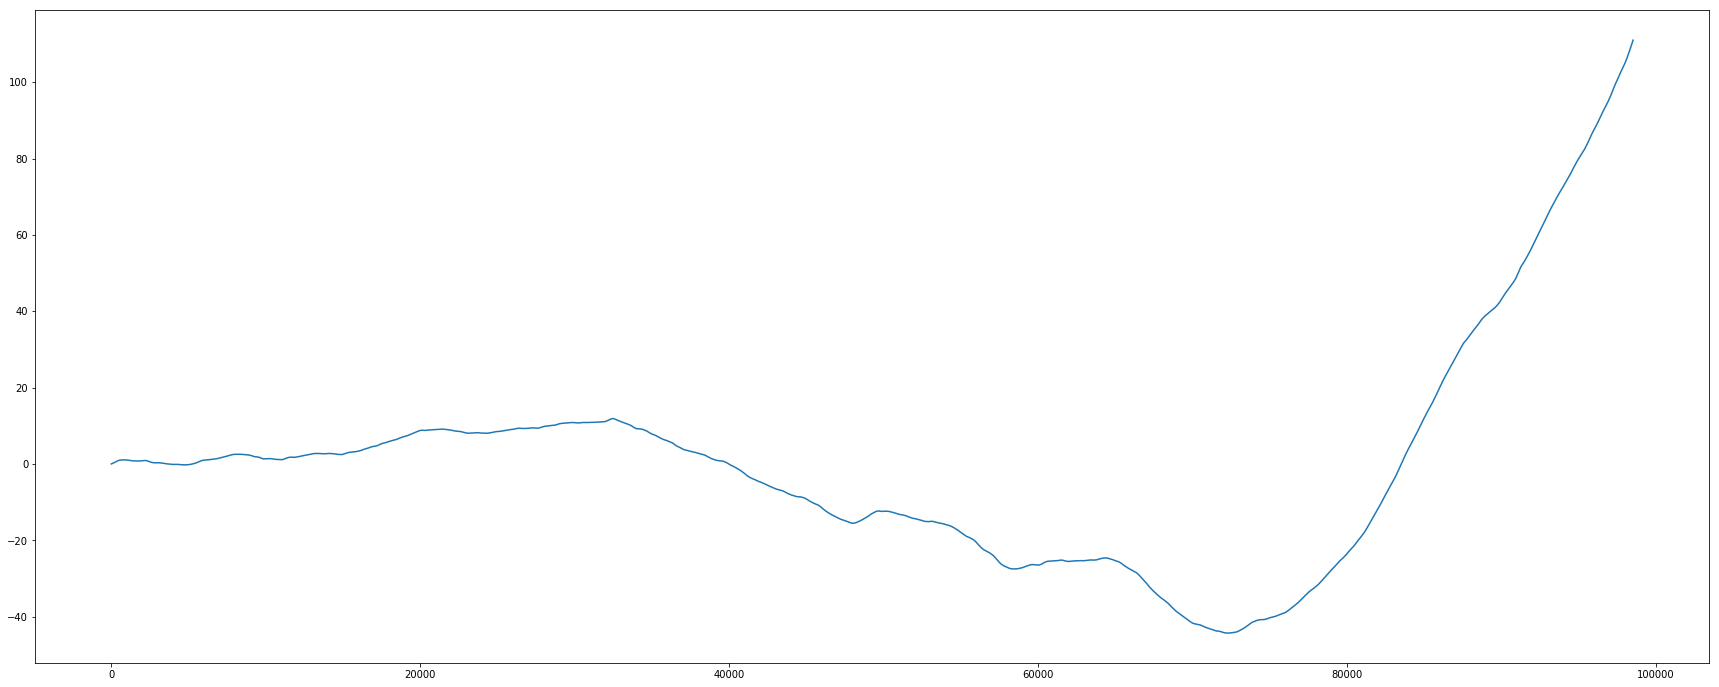

In [44]:
corr_ts(df[(df['s2'] == 0)]['y1'])
corr_ts(df[(df['s2'] == 1)]['y1'])

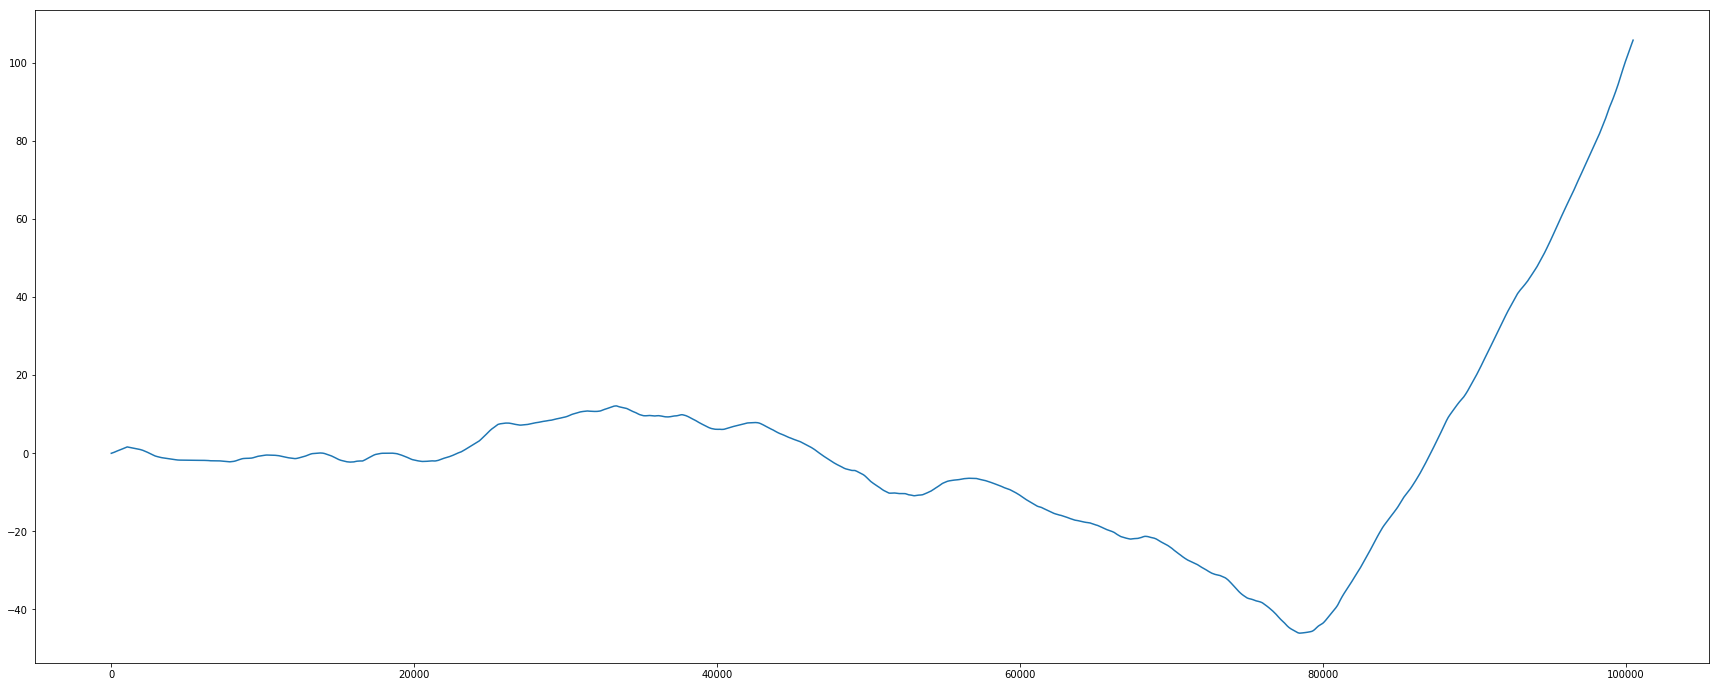

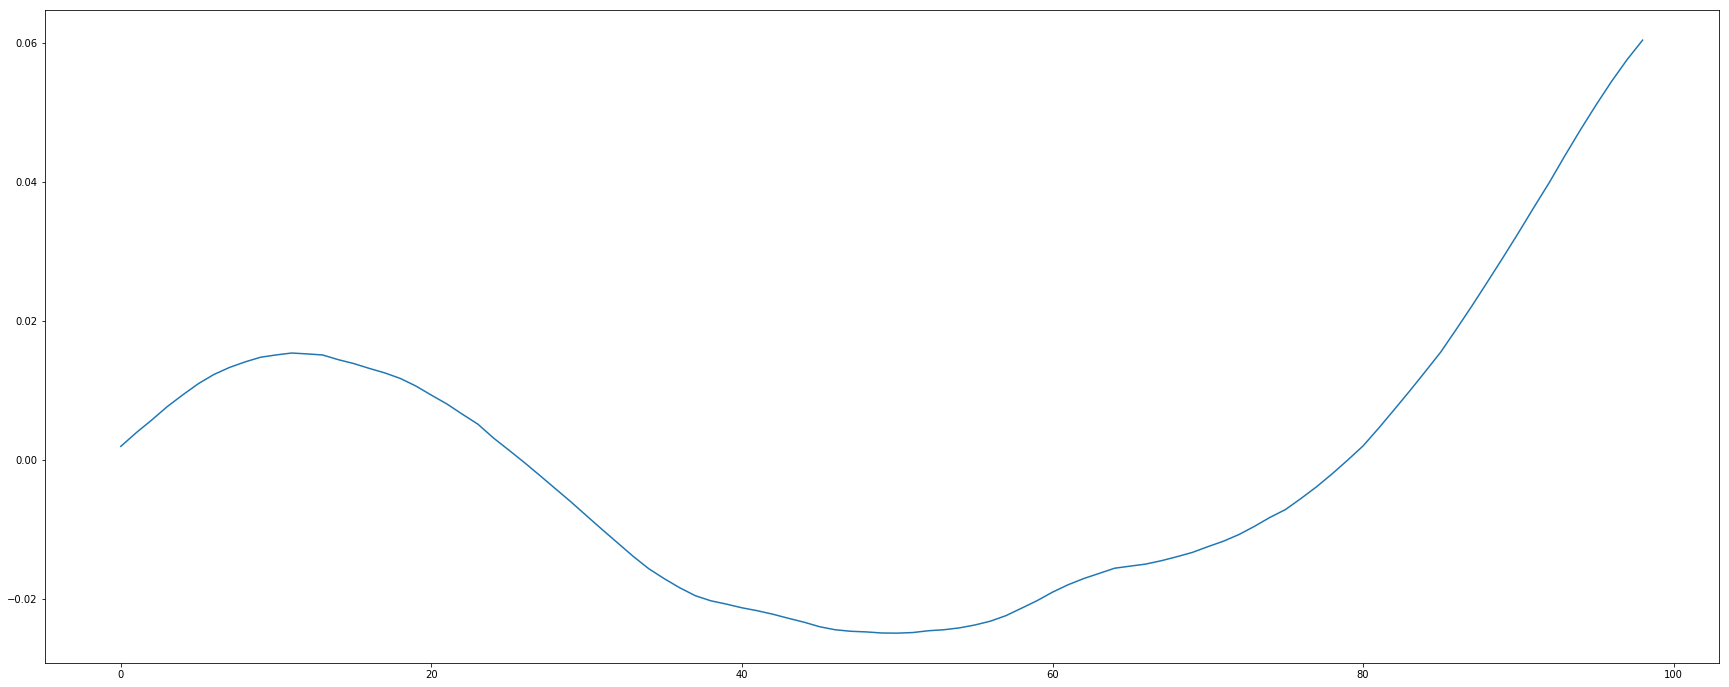

In [45]:
corr_ts(df[(df['s1'] == 0)]['y1'])
corr_ts(df[(df['s1'] == 1)]['y1'][:100])

# 2.Построение 

In [46]:
df["y"] = df['y1'].shift(-1)
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,s1,s2,y1,y
0,996.7459,1001.2642,999.1467,997.4923,999.7231,1000.8404,999.3012,998.4121,0,1,995.2712,995.2380
1,996.6976,1001.2588,999.1436,997.5075,999.7024,1000.8533,999.3144,998.4018,0,1,995.2380,995.2146
2,996.6631,1001.2644,999.1461,997.4998,999.7481,1000.8321,999.3057,998.4034,0,1,995.2146,995.1892
3,996.6342,1001.2723,999.1480,997.5134,999.7333,1000.8421,999.2866,998.4075,0,1,995.1892,995.1890
4,996.6195,1001.2735,999.1411,997.5150,999.7638,1000.8392,999.2458,998.4168,0,1,995.1890,995.1792


## 2.1.Функция генерации смещений

In [47]:
def prepareData(data_, columns_ = [], lag_start=5, lag_end=20, test_size=0.15, print_=True):
    
    data = pd.DataFrame(data_.copy())
    data.columns = data_.columns
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int((1-test_size)*data.shape[0])
    
    # добавляем лаги исходного ряда в качестве признаков
    for j in columns_:
        for i in range(lag_start, lag_end):
            data["{}_lag_{}".format(j,i)] = data[j].shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    if print_:
        print(data.info(verbose=False,memory_usage='deep'),end='\n\n')
    
    return X_train, X_test, y_train, y_test

## 2.2Визуализация prediction & test

In [48]:
def plot_prediction_Linear_regression(y_test, prediction):
    plt.figure(figsize=(19, 10))
    plt.plot(y_test.values - prediction, "r", label="actual - prediction")
    plt.legend(loc="best")
    plt.title("Linear regression\n test score {} point".format(rmse(prediction, y_test)))
    plt.grid(True);
    
def plot_prediction_Linear_regression_p(y_test, prediction):
    plt.figure(figsize=(19, 10))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Linear regression\n test score {} point".format(rmse(y_test,prediction)))
    plt.grid(True);

## 2.3.Ошибки

In [49]:
def mae(y, p):
    return mean_absolute_error(y, p)

def rmse(y, p):
    return np.sqrt(mean_squared_error(y, p))

## 2.4.Функция сортировки значимых коэф.

In [50]:
def beatiful_coef(coefs, feature_names=df.columns[:-1]):
    return pd.DataFrame(np.abs(coefs), index=feature_names, columns=['coef_abs']).\
                            sort_values('coef_abs',ascending=False)

In [51]:
#pd.DataFrame.sort_values?

# 3.Предсказания
## 3.1. Предсказание по предыдущему значению

In [52]:
%%time
tscv = TimeSeriesSplit(n_splits=10)

X_train, X_test, y_train, y_test = prepareData(df[['y1','y']], test_size=0.1, lag_start=1, lag_end=15)
lr_base = LinearRegression(normalize=True, n_jobs=-1)
lr_base.fit(X_train.values, y_train.values)
score_cv = np.sqrt(abs(np.mean(cross_val_score(lr_base, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction_base = lr_base.predict(X_test.values)
#plot_prediction_Linear_regression(y_test,prediction)
print('train CV score = {}'.format(score_cv))
print('test score = {}'.format(rmse(y_test.values,prediction_base)))
print('Значимость коэф.:')
print(beatiful_coef(lr_base.coef_, feature_names=X_train.columns).head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Columns: 2 entries, y1 to y
dtypes: float64(2)
memory usage: 3.1 MB
None

train CV score = 0.03981321821042575
test score = 0.04008961256606465
Значимость коэф.:
    coef_abs
y1  0.999995
CPU times: user 100 ms, sys: 168 ms, total: 268 ms
Wall time: 2.61 s


## 3.2.Модель, которая предсказывает "то же самое значение что и сейчас"
Нужна для анализа

Модель, которая предсказывает "то же самое значение что и сейчас".
score = 0.04009262896860505


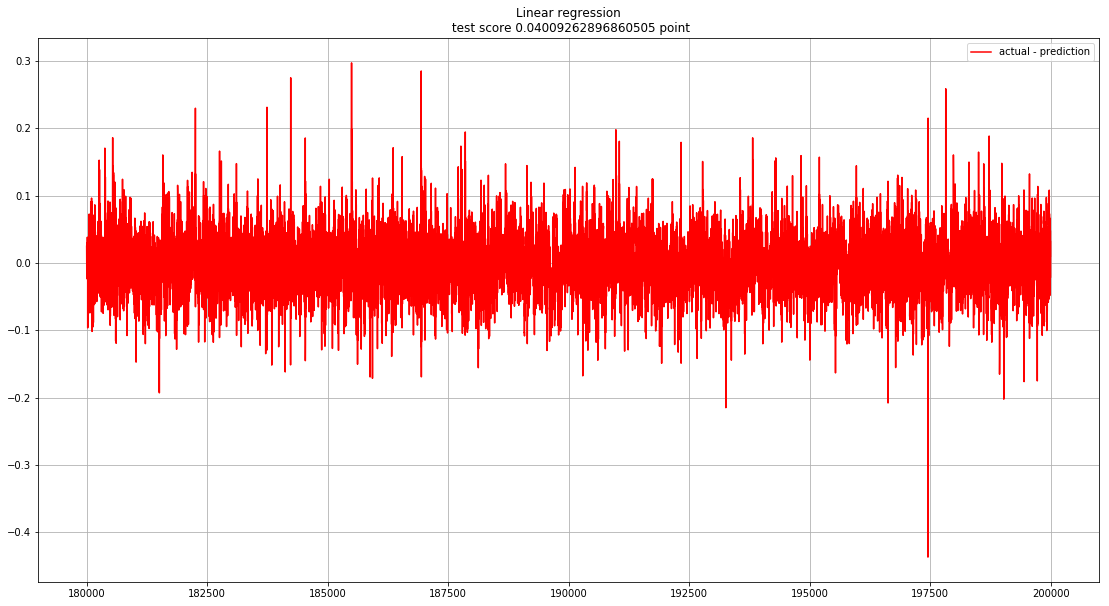

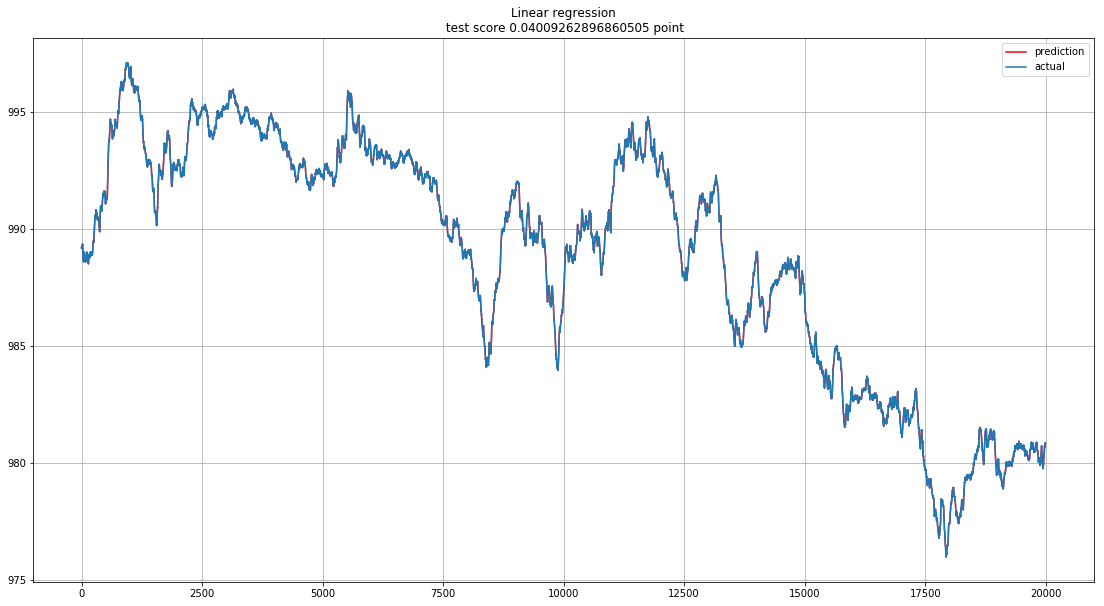

In [87]:
print('Модель, которая предсказывает "то же самое значение что и сейчас".\nscore = {}'.\
      format(rmse(y_test,X_test['y1'])))
plot_prediction_Linear_regression(y_test,X_test['y1'])
plot_prediction_Linear_regression_p(y_test,X_test['y1'].values)

## 3.3. Предсказание по предыдущему значению всех сигналов

In [54]:
%%time
X_train, X_test, y_train, y_test = prepareData(df, test_size=0.1, lag_start=1, lag_end=7)
lr = LinearRegression(normalize=True, n_jobs=-1)
lr.fit(X_train.values, y_train.values)

score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
#plot_prediction_Linear_regression(y_test,prediction)
print('train CV score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Columns: 12 entries, x1 to y
dtypes: float64(10), int64(2)
memory usage: 18.3 MB
None

train CV score:	0.04003797921825724
test score:	0.04013090912545876
Значимость коэф.:
    coef_abs
y1  0.999916
s1  0.000821
x5  0.000263
x6  0.000133
x3  0.000088
x7  0.000085
x2  0.000083
s2  0.000055
x8  0.000052
x4  0.000038
x1  0.000009
CPU times: user 292 ms, sys: 196 ms, total: 488 ms
Wall time: 1.07 s


На трейне значение лучше, чем "предсказание будущего, как сейчас"

На тесте -- хуже

## 3.4. Модель, предсказания по предыдущим значениям целевой переменно
с "взглядом" в прошлое на 15 единиц

In [55]:
%%time
X_train, X_test, y_train, y_test = prepareData(df[['y1','y']], columns_= ['y1'], test_size=0.1, 
                                               lag_start=1, lag_end=15)
lr = LinearRegression(normalize=True, n_jobs=-1)
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
#plot_prediction_Linear_regression(y_test,prediction)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199985 entries, 0 to 199984
Columns: 16 entries, y1 to y1_lag_14
dtypes: float64(16)
memory usage: 24.4 MB
None

train cv score:	0.03073609187429537
test score:	0.030606074879867738
Значимость коэф.:
           coef_abs
y1         0.905812
y1_lag_1   0.647136
y1_lag_2   0.465789
y1_lag_4   0.094963
y1_lag_6   0.018978
y1_lag_5   0.014331
y1_lag_3   0.011283
y1_lag_8   0.008195
y1_lag_7   0.006227
y1_lag_9   0.005720
y1_lag_13  0.004791
y1_lag_14  0.001811
y1_lag_11  0.001252
y1_lag_12  0.000849
y1_lag_10  0.000785
CPU times: user 396 ms, sys: 260 ms, total: 656 ms
Wall time: 1.46 s


На валидации и на трейне, получили значительный прирост точности

## 3.5 Модель, с "взглядом в прошлое" по всем сигналам

In [56]:
%%time
X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1, lag_start=1, lag_end=7)
lr = LinearRegression(normalize=True, n_jobs=-1)
lr.fit(X_train.values, y_train.values)

score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
#plot_prediction_Linear_regression(y_test,prediction)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199993 entries, 0 to 199992
Columns: 78 entries, x1 to y1_lag_6
dtypes: float64(76), int64(2)
memory usage: 119.0 MB
None

train cv score:	0.02275745505665534
test score:	0.02239173297531402
Значимость коэф.:
          coef_abs
y1        0.795613
y1_lag_1  0.657811
x5        0.513571
x1        0.494408
x3        0.494301
x2        0.478346
x4        0.467381
x5_lag_1  0.412695
x3_lag_1  0.392176
x1_lag_1  0.385105
x2_lag_1  0.383736
x4_lag_1  0.369500
x5_lag_2  0.337456
x1_lag_2  0.331059
x3_lag_2  0.324671
x2_lag_2  0.311739
x4_lag_2  0.310353
y1_lag_2  0.301227
x5_lag_3  0.154908
x2_lag_3  0.150199
CPU times: user 5.26 s, sys: 1.28 s, total: 6.54 s
Wall time: 13.7 s


Ещё один значительный прирост, на кросс валидации и на тесте

### 3.5.1 Подберём начало, конец и интервал лага
** начнём с конца **

In [57]:
def plot_lag_cv(i,y):
    plt.figure(figsize=(12,4))
    plt.plot(i,[y_[0] for y_ in y], 'x--', label="train cv")
    plt.plot(i,[y_[1] for y_ in y], 'x--', label="test")
    plt.legend(loc="mae")
    plt.title("Linear regression\n min train CV score= {} (i:{}) point".
              format(np.min([y_[0] for y_ in y]),i[np.argmin([y_[0] for y_ in y])]))
    plt.grid(True);

In [58]:
def lag_bn_cv(begin_=0, end_=14, step_=1,n_splits_=5, i_is_end=True):
    tscv = TimeSeriesSplit(n_splits=n_splits_)

    print('Begin CV lag ({},{},{}), i is end:{}'.format(begin_,end_,step_,i_is_end),end='\n\n')
    m_a_e_list = []
    i_list = []
    for i in np.arange(begin_,end_,step_):
        if i_is_end:
            X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=i, print_=False)
        else:
            X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=i, lag_end=10, print_=False)
        
            
        lr = LinearRegression(normalize=True, n_jobs=-1)
        lr.fit(X_train.values, y_train.values)
        score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
                                           cv=tscv, n_jobs=-1, 
                                           scoring='neg_mean_squared_error'))))
        prediction = lr.predict(X_test.values)
        #plot_prediction_Linear_regression(y_test,prediction)
        #print('CV mean absolute error = {}'.format(score_cv))
        #print('mean absolute error = {}'.format(mae(y_test.values,prediction)))
        #print('Значимость коэф.:')
        #print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head(20))
        m_a_e_list.append((score_cv, rmse(y_test.values,prediction)))
        i_list.append(i)
        print('\r i:{} train cv:{} test:{}'.format(i,score_cv,rmse(y_test.values,prediction)), end='')
    print()
    return i_list,m_a_e_list

Begin CV lag (0,25,4), i is end:True

 i:24 train cv:0.02265145261729862 test:0.0224077259332226078
CPU times: user 1min 11s, sys: 20.6 s, total: 1min 31s
Wall time: 2min 9s


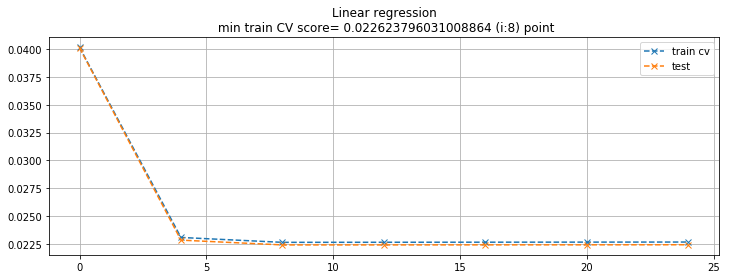

In [59]:
%%time

i_list,m_a_e_list = lag_bn_cv(begin_=0, end_=25, step_=4,n_splits_=5)
plot_lag_cv(i_list,m_a_e_list)

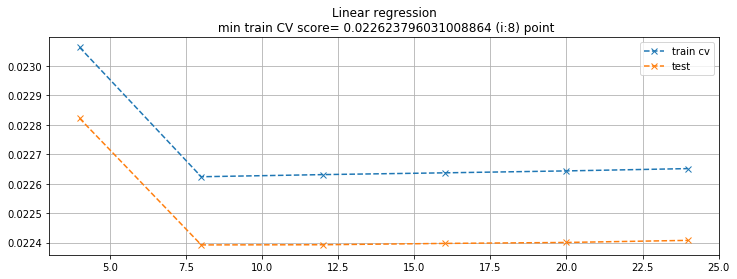

In [60]:
plot_lag_cv(i_list[1:],m_a_e_list[1:])

Begin CV lag (4,16,1), i is end:True

 i:15 train cv:0.02263618433320507 test:0.022396251245214358
CPU times: user 1min 42s, sys: 24.4 s, total: 2min 7s
Wall time: 2min 24s


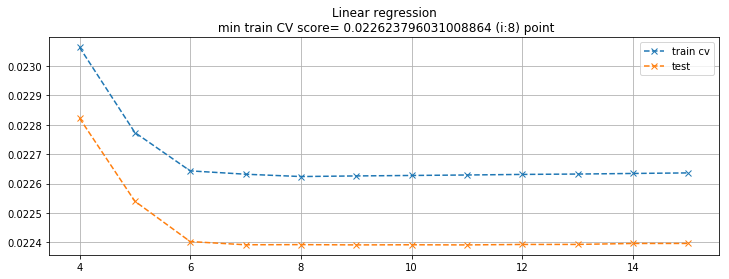

In [61]:
%%time

i_list,m_a_e_list = lag_bn_cv(begin_=4, end_=16, step_=1,n_splits_=5)
plot_lag_cv(i_list,m_a_e_list)

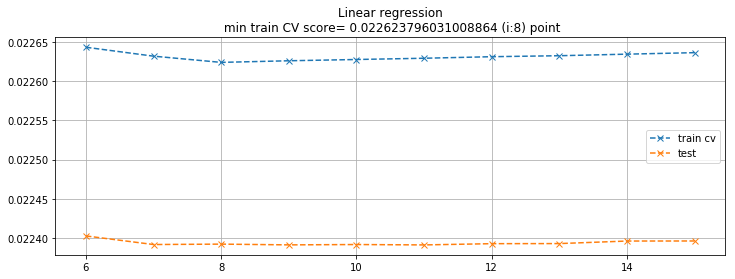

In [62]:
plot_lag_cv(i_list[2:],m_a_e_list[2:])

Begin CV lag (7,11,1), i is end:True

 i:10 train cv:0.02262747303590745 test:0.022391725093229442
CPU times: user 31.4 s, sys: 7.37 s, total: 38.7 s
Wall time: 44 s


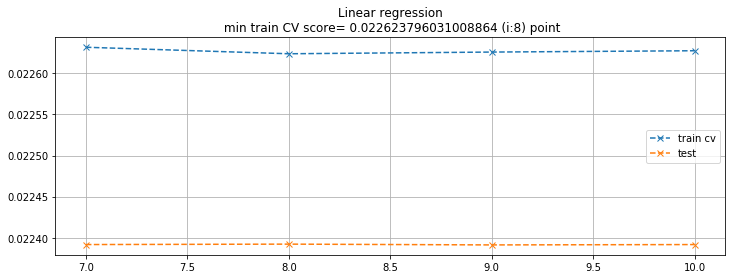

In [63]:
%%time

i_list,m_a_e_list = lag_bn_cv(begin_=7, end_=11, step_=1,n_splits_=5)
plot_lag_cv(i_list,m_a_e_list)

**Теперь займёмся началом**

Begin CV lag (1,9,1), i is end:False

 i:8 train cv:0.03587504732379117 test:0.0354465843861252465
CPU times: user 41.5 s, sys: 11.1 s, total: 52.6 s
Wall time: 59.5 s


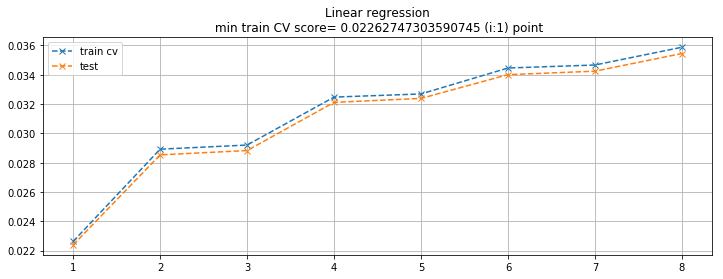

In [64]:
%%time

i_list,m_a_e_list = lag_bn_cv(begin_=1, end_=9, step_=1,n_splits_=5, i_is_end=False)
plot_lag_cv(i_list,m_a_e_list)

** Построим промежуточный лучший результат ** и выведим признаки по их "важности"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199992 entries, 0 to 199991
Columns: 89 entries, x1 to y1_lag_7
dtypes: float64(87), int64(2)
memory usage: 135.8 MB
None

train cv score:	0.022749271809385137
test score:	0.022392245817200562
Значимость коэф.:
          coef_abs
y1        0.795135
y1_lag_1  0.654944
x5        0.513650
x1        0.494358
x3        0.494330
x2        0.478286
x4        0.467378
x5_lag_1  0.412545
x3_lag_1  0.391984
x1_lag_1  0.384922
x2_lag_1  0.383627
x4_lag_1  0.369128
x5_lag_2  0.336101
x1_lag_2  0.329487
x3_lag_2  0.323247
x2_lag_2  0.310008
x4_lag_2  0.309087
y1_lag_2  0.300659
x5_lag_3  0.154743
x2_lag_3  0.149867


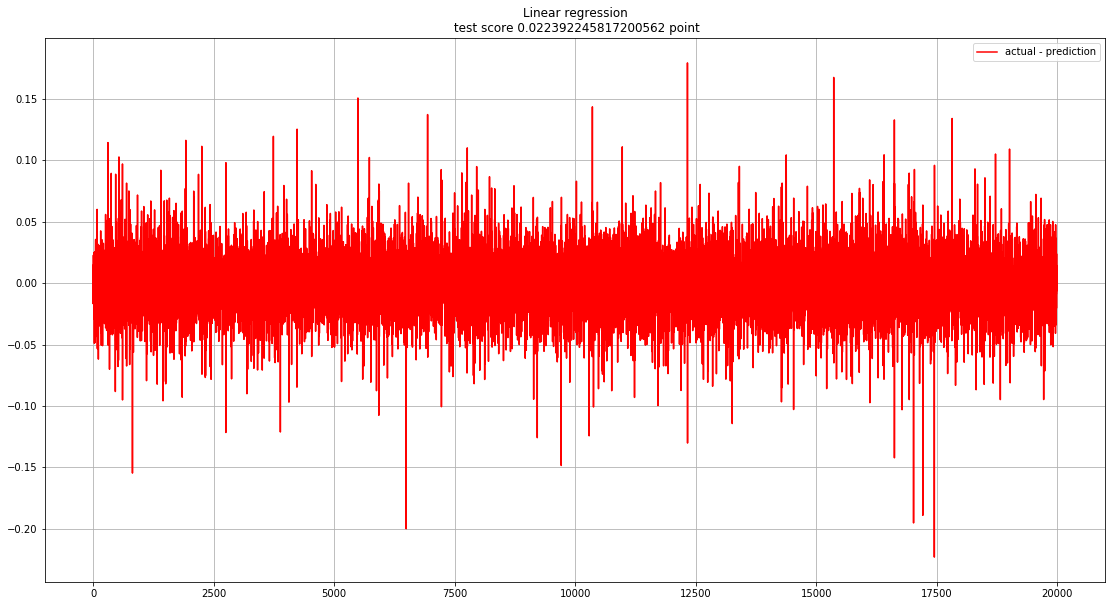

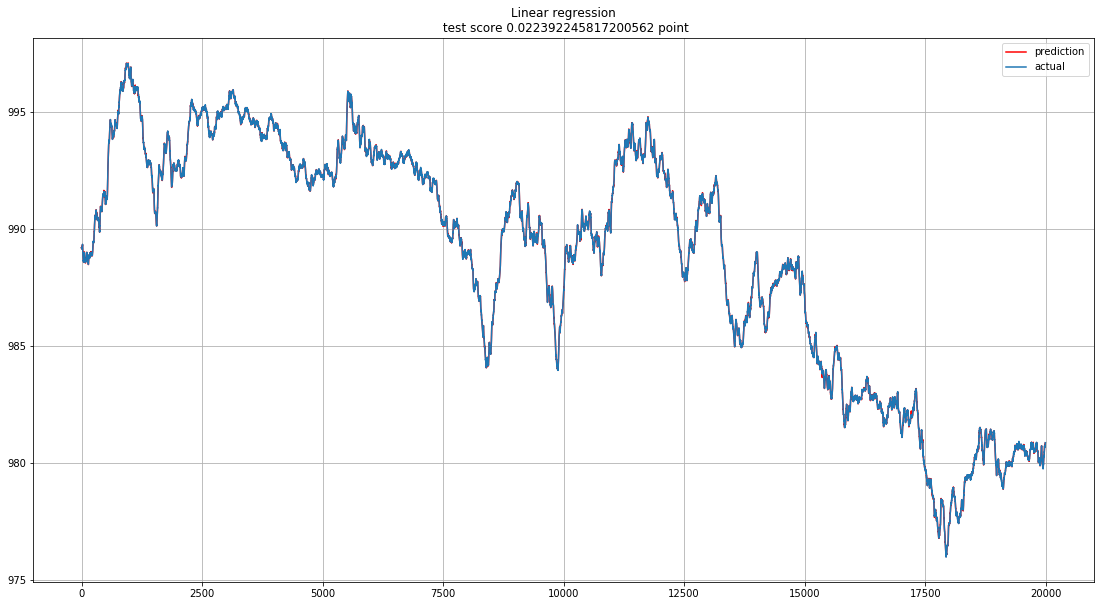

In [65]:
tscv = TimeSeriesSplit(n_splits=10)

X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=True)
lr_mid = LinearRegression(normalize=True, n_jobs=-1)
lr_mid.fit(X_train.values, y_train.values)
score_cv = np.sqrt(abs(np.mean(cross_val_score(lr_mid, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr_mid.predict(X_test.values)
plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr_mid.coef_, feature_names=X_train.columns).head(20))

** Попробуем уменьшить размер нашей модели **

для этого, попробуем построить нашу модель на подвыборках значимых признаков

In [66]:
top_coef = beatiful_coef(lr_mid.coef_, feature_names=X_train.columns).index
top_coef

Index(['y1', 'y1_lag_1', 'x5', 'x1', 'x3', 'x2', 'x4', 'x5_lag_1', 'x3_lag_1',
       'x1_lag_1', 'x2_lag_1', 'x4_lag_1', 'x5_lag_2', 'x1_lag_2', 'x3_lag_2',
       'x2_lag_2', 'x4_lag_2', 'y1_lag_2', 'x5_lag_3', 'x2_lag_3', 'x3_lag_3',
       'x4_lag_3', 'x1_lag_3', 'y1_lag_4', 'x5_lag_5', 'x3_lag_5', 'x1_lag_5',
       'x2_lag_5', 'x4_lag_5', 'y1_lag_6', 'x2_lag_7', 'x5_lag_7', 'x3_lag_7',
       'x4_lag_7', 'x1_lag_7', 'x2_lag_6', 'x5_lag_6', 'x1_lag_4', 'x6_lag_3',
       'y1_lag_3', 'x8_lag_2', 'x6_lag_4', 'y1_lag_5', 'x8_lag_4', 'x8_lag_6',
       'x3_lag_4', 'x2_lag_4', 'x8_lag_5', 'x4_lag_6', 'x8_lag_1', 'x7_lag_3',
       'x7_lag_7', 'x6_lag_6', 'x7_lag_5', 'x7_lag_4', 'x6_lag_2', 's1_lag_6',
       'x8_lag_7', 'x5_lag_4', 'x6', 's1_lag_5', 'x6_lag_1', 'x8_lag_3',
       's2_lag_4', 'x7_lag_1', 's2_lag_1', 'x7_lag_2', 'x3_lag_6', 'x7_lag_6',
       'x6_lag_7', 'y1_lag_7', 'x6_lag_5', 's2_lag_7', 'x7', 's2', 's1',
       'x4_lag_4', 's1_lag_7', 's2_lag_3', 's2_lag_2', 'x8', 's1

In [67]:
tscv = TimeSeriesSplit(n_splits=5)
def top_coef_cv(begin_=0, end_=14, step_=1):
    m_a_e_list = []
    i_list = []

    X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                           lag_start=1, lag_end=8, print_=False)
    
    print('Begin CV top_coef, ({},{},{})'.format(begin_,end_,step_),end='\n\n')
    for i_top_coef in np.arange(begin_,end_,step_):
        lr = LinearRegression(normalize=True, n_jobs=-1)
        lr.fit(X_train[top_coef[:i_top_coef]].values, y_train.values)
        score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train[top_coef[:i_top_coef]].values, y_train.values, 
                                               cv=tscv, n_jobs=-1, 
                                               scoring='neg_mean_squared_error'))))
        prediction = lr.predict(X_test[top_coef[:i_top_coef]].values)

        m_a_e_list.append((score_cv, rmse(y_test.values,prediction)))
        i_list.append(i_top_coef)
        print('\r len top coef.:{} CV:{} test:{}'.format(i_top_coef,score_cv,rmse(y_test.values,prediction)), end='')
    print()
    return i_list,m_a_e_list

Begin CV top_coef, (10,88,5)

 len top coef.:85 CV:0.022748220572124802 test:0.022392292886704995
CPU times: user 40 s, sys: 14.5 s, total: 54.6 s
Wall time: 1min 50s


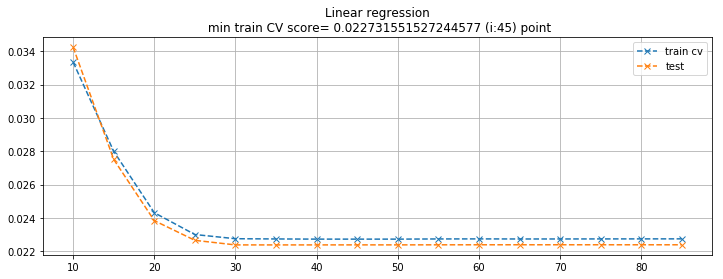

In [68]:
%%time
tscv = TimeSeriesSplit(n_splits=10)
i_list,m_a_e_list = top_coef_cv(begin_=10, end_=len(top_coef), step_=5)
plot_lag_cv(i_list,m_a_e_list)

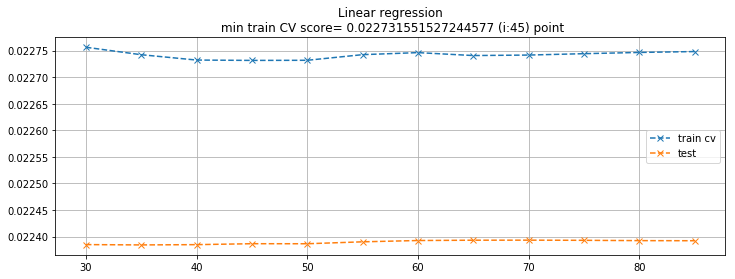

In [69]:
plot_lag_cv(i_list[4:],m_a_e_list[4:])

Begin CV top_coef, (34,55,1)

 len top coef.:54 CV:0.022742269794434604 test:0.022390237577298167
CPU times: user 38.1 s, sys: 14.1 s, total: 52.2 s
Wall time: 1min 47s


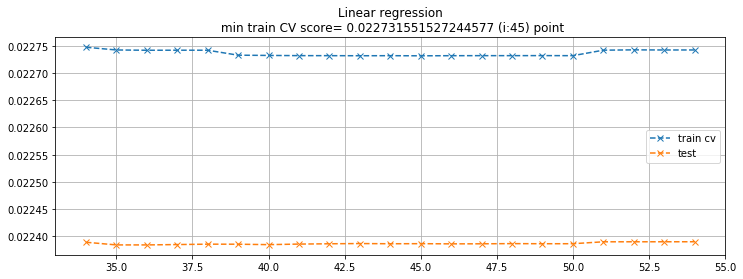

In [70]:
%%time

i_list,m_a_e_list = top_coef_cv(begin_=34, end_=55, step_=1)
plot_lag_cv(i_list,m_a_e_list)

Удалось уменьшить колличество необходимых признаков почти в 2 раза, и при этом получить не значительный прирость точности

## Итоговая модель

train cv score:	0.022731551527244577
test score:	0.02238670617958793
Значимость коэф.:
          coef_abs
y1        0.794815
y1_lag_1  0.655696
x5        0.513672
x1        0.494414
x3        0.494345
x2        0.478206
x4        0.467314
x5_lag_1  0.412905
x3_lag_1  0.390428
x1_lag_1  0.384833
x2_lag_1  0.382694
x4_lag_1  0.369554
x5_lag_2  0.335116
x1_lag_2  0.329812
x3_lag_2  0.327378
x2_lag_2  0.311763
x4_lag_2  0.308272
y1_lag_2  0.300693
x5_lag_3  0.155362
x2_lag_3  0.148870
CPU times: user 2.41 s, sys: 832 ms, total: 3.24 s
Wall time: 6.02 s


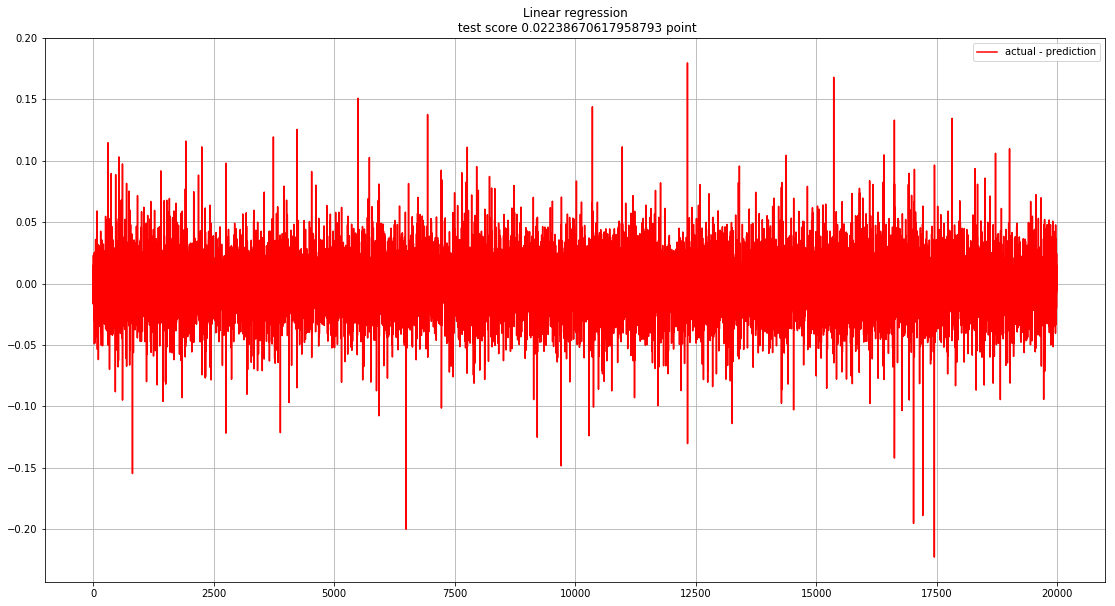

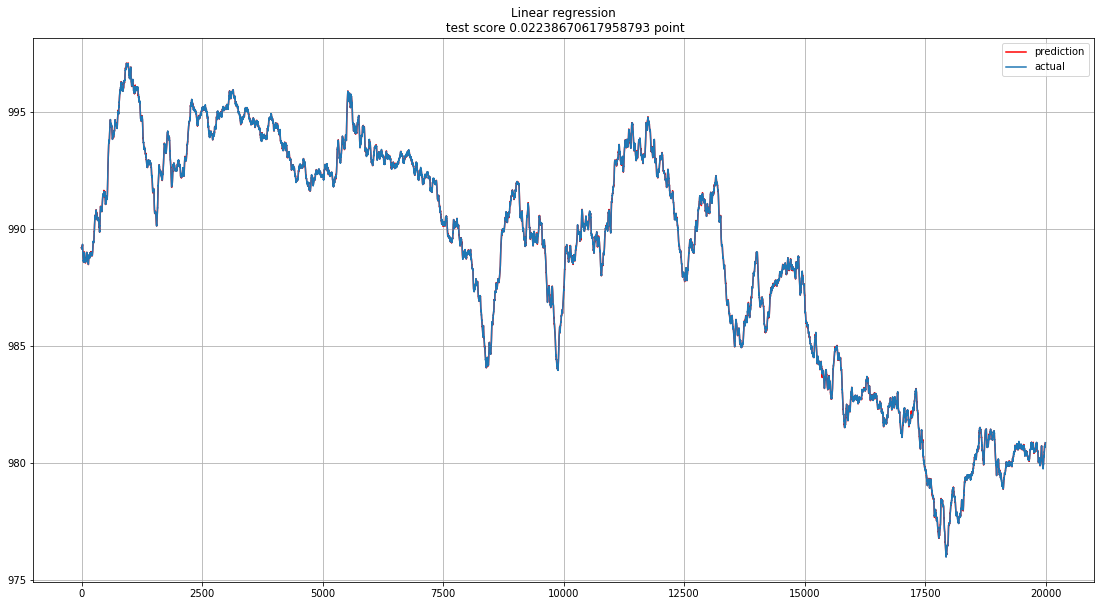

In [71]:
%%time
tscv = TimeSeriesSplit(n_splits=10)

X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
X_train, X_test = X_train[top_coef[:45]], X_test[top_coef[:45]]

lr_final = LinearRegression(normalize=True, n_jobs=-1)
lr_final.fit(X_train.values, y_train.values)
score_cv = np.sqrt(abs(np.mean(cross_val_score(lr_final, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr_final.predict(X_test.values)
plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr_final.coef_, feature_names=X_train.columns).head(20))



# Сравнение с подельню, "завтра так же как и сегодня"

Да, на граффиках не сильно заметны красные точки -_-

У модели "завтра так же как и сегодня":
* score:	0.040089237364909595

У нашей последней подели:    
* score (test): 	0.02238670617958793
* score (train): 	0.022731551527244577

Удалось **почти в 2 наза**, уменьшить потери при прогназировании.

### Сгенерируем белый шум

Text(0,0.5,'Linear spectrum [V RMS]')

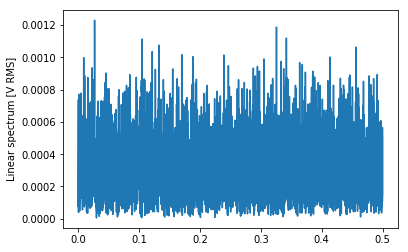

In [72]:


x = np.random.normal(scale=0.02, size=len(y_test))
f, Pxx_spec = signal.periodogram(x, window= 'flattop', scaling='spectrum')
plt.plot(f, np.sqrt(Pxx_spec))
plt.ylabel('Linear spectrum [V RMS]')

Text(0,0.5,'Linear spectrum [V RMS]')

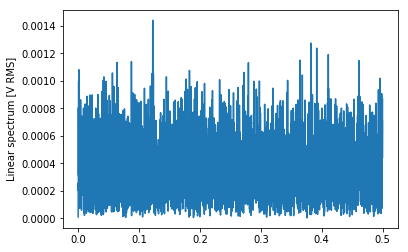

In [73]:

f, Pxx_spec = signal.periodogram(y_test-prediction, window= 'flattop', scaling='spectrum')
plt.plot(f, np.sqrt(Pxx_spec))
plt.ylabel('Linear spectrum [V RMS]')

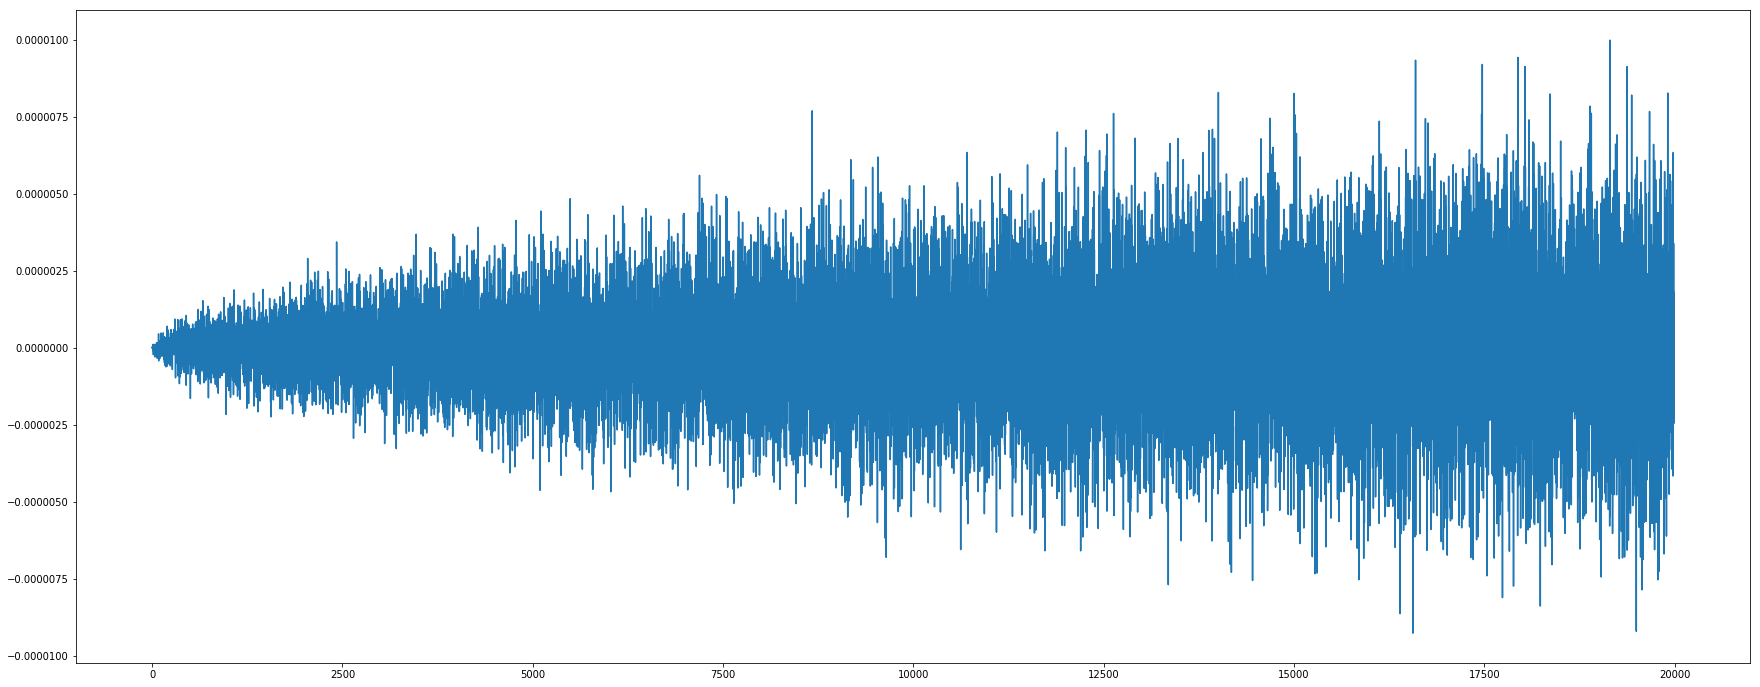

In [74]:
corr_ts(x)

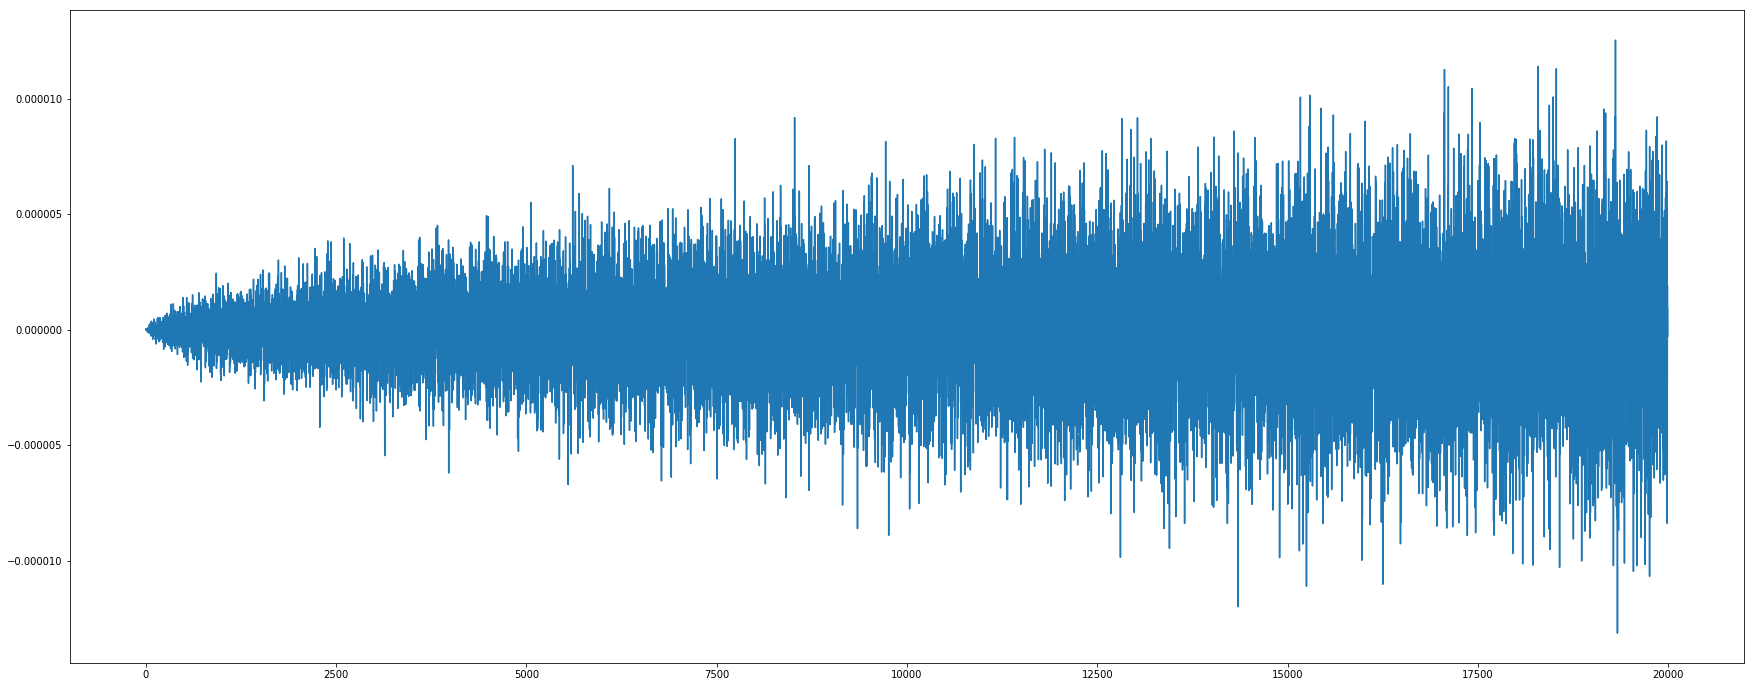

In [75]:
corr_ts(y_test-prediction)

** Спектрограмма и коррелограмма регрессионных остатков похожа на спектр. и корр.белого шума.**

# Попробуем применить Lasso & Ridge
спойлер:
* не очень то и получилось c Lasso
* c Ridge, получилось очнеь даже годно, сравниво стем, что приведено чуть выше, а именно:
    * score:  

train cv score:	6.742385289307899
test score:	5.8947622548020275
Значимость коэф.:
          coef_abs
y1        0.578377
y1_lag_4  0.000000
x3_lag_5  0.000000
x1_lag_5  0.000000
x2_lag_5  0.000000
CPU times: user 1.04 s, sys: 716 ms, total: 1.76 s
Wall time: 3.32 s


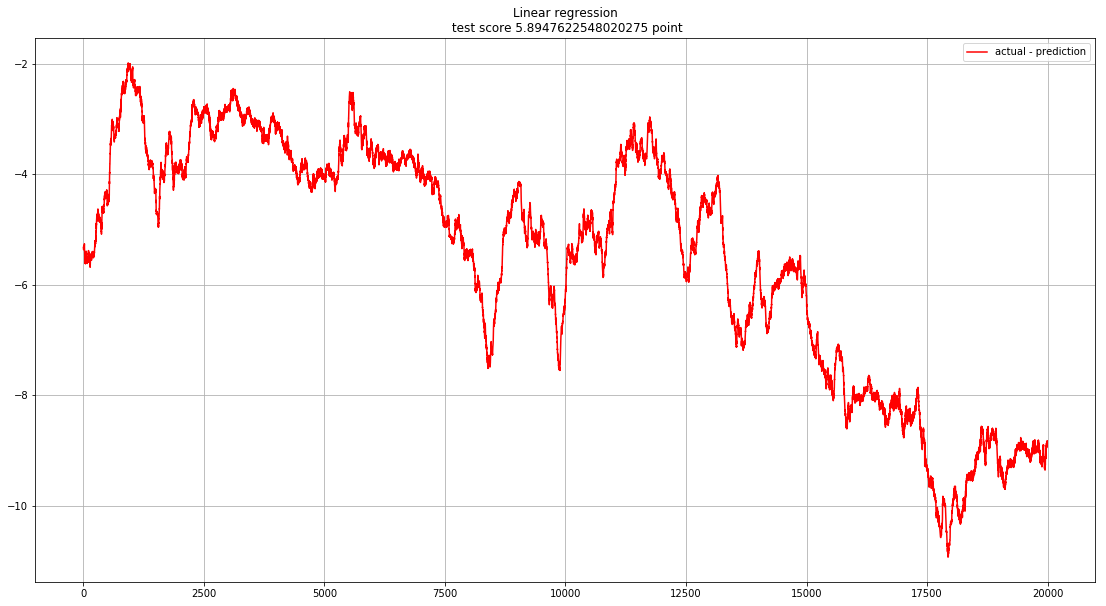

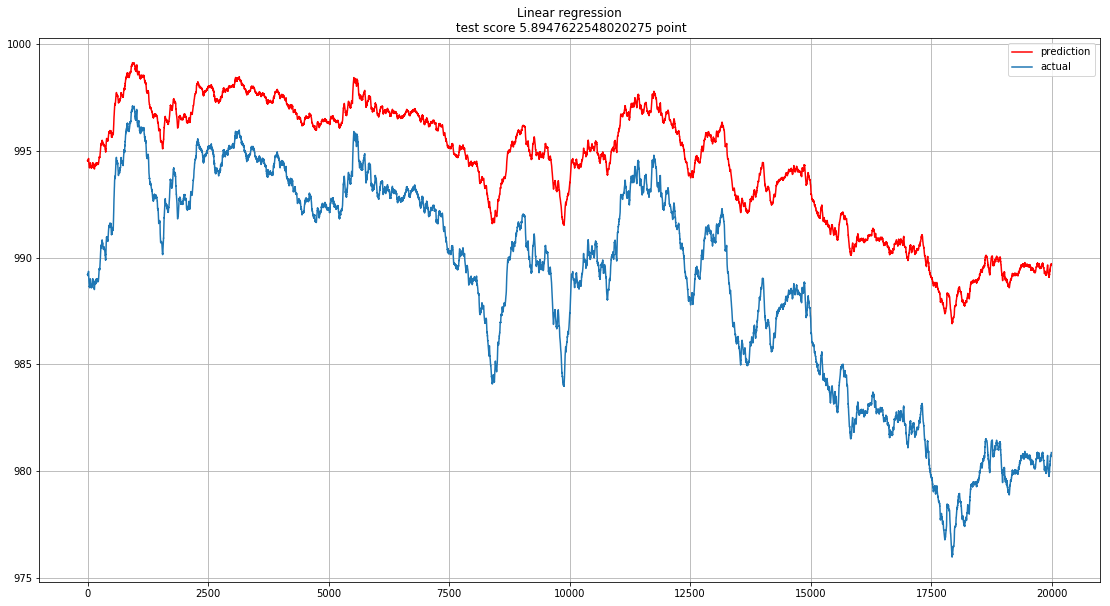

In [76]:


%%time
tscv = TimeSeriesSplit(n_splits=10)

X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
X_train, X_test = X_train[top_coef[:45]], X_test[top_coef[:45]]

lr = Lasso(0.01, normalize=True)
lr.fit(X_train.values, y_train.values)
score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head())


train cv score:	0.03965964775424713
test score:	0.0400818955983523
Значимость коэф.:
          coef_abs
y1        1.000009
x3_lag_1  0.000303
x3_lag_3  0.000195
x3        0.000167
x5        0.000136
x6_lag_3  0.000131
x3_lag_2  0.000123
x8_lag_2  0.000074
x5_lag_3  0.000060
x3_lag_5  0.000052
x5_lag_2  0.000040
x5_lag_6  0.000037
x5_lag_5  0.000027
x5_lag_1  0.000025
y1_lag_4  0.000023
x1_lag_2  0.000020
y1_lag_5  0.000018
x6_lag_4  0.000018
x1_lag_7  0.000016
x1_lag_3  0.000015
CPU times: user 1.18 s, sys: 708 ms, total: 1.89 s
Wall time: 4.49 s


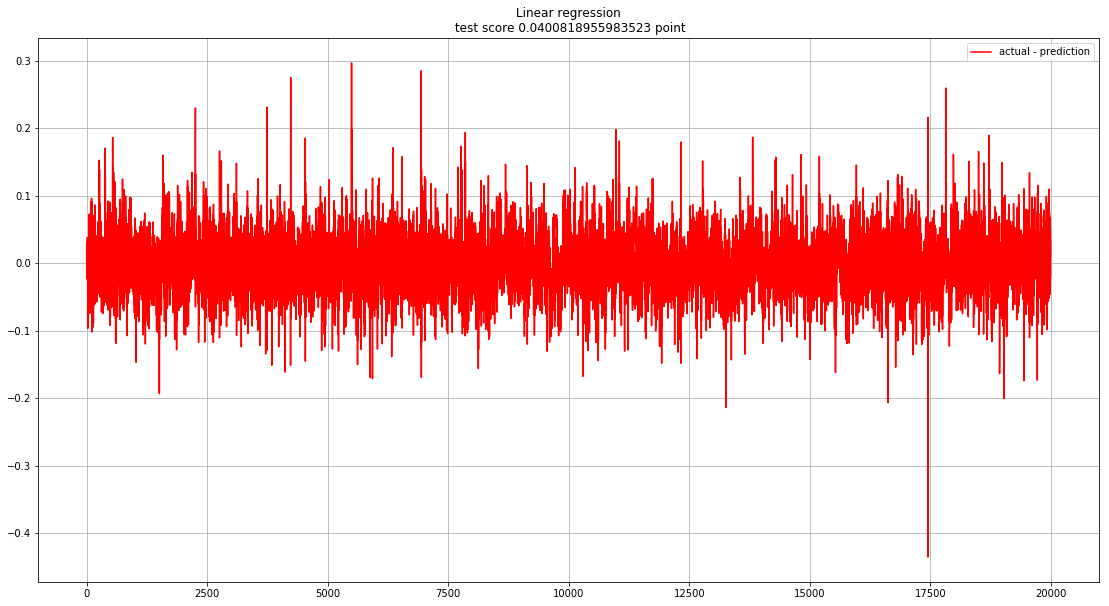

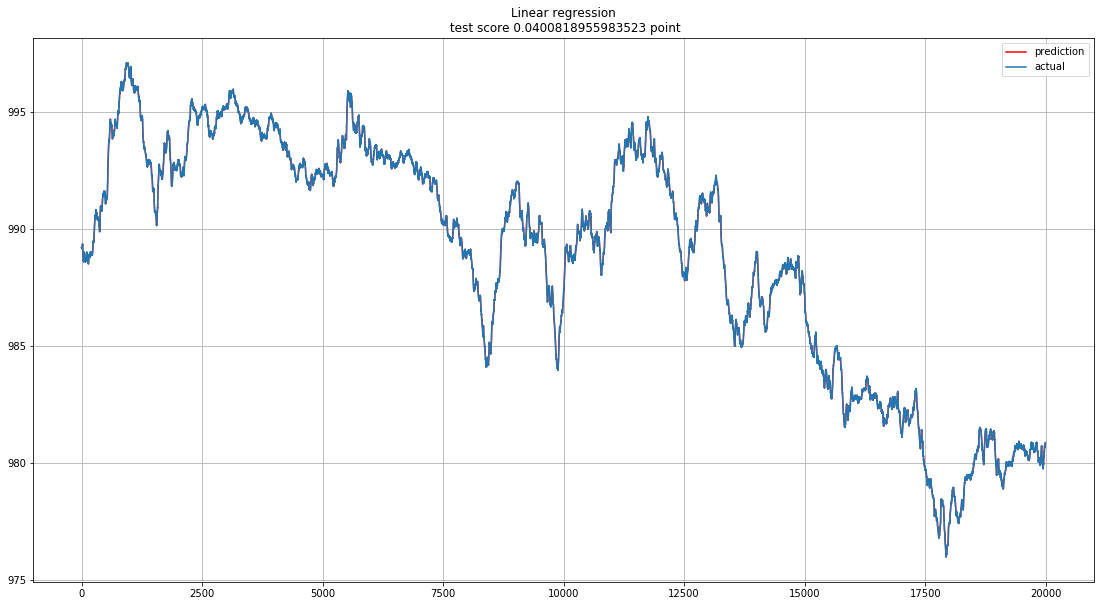

In [77]:
%%time
tscv = TimeSeriesSplit(n_splits=10)

X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
X_train, X_test = X_train[top_coef[:45]], X_test[top_coef[:45]]

lr = Lasso(.0, normalize=True)
lr.fit(X_train.values, y_train.values)
score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head(20))

alpha: -4.34343434343e-07
train cv score:	0.03853760551259892
test score:	0.04009160351501918
Значимость коэф.:
          coef_abs
y1        1.000030
x3_lag_2  0.000738
x3_lag_7  0.000616
x3_lag_5  0.000582
x6_lag_4  0.000545
CPU times: user 4.94 s, sys: 3.55 s, total: 8.49 s
Wall time: 1min 28s


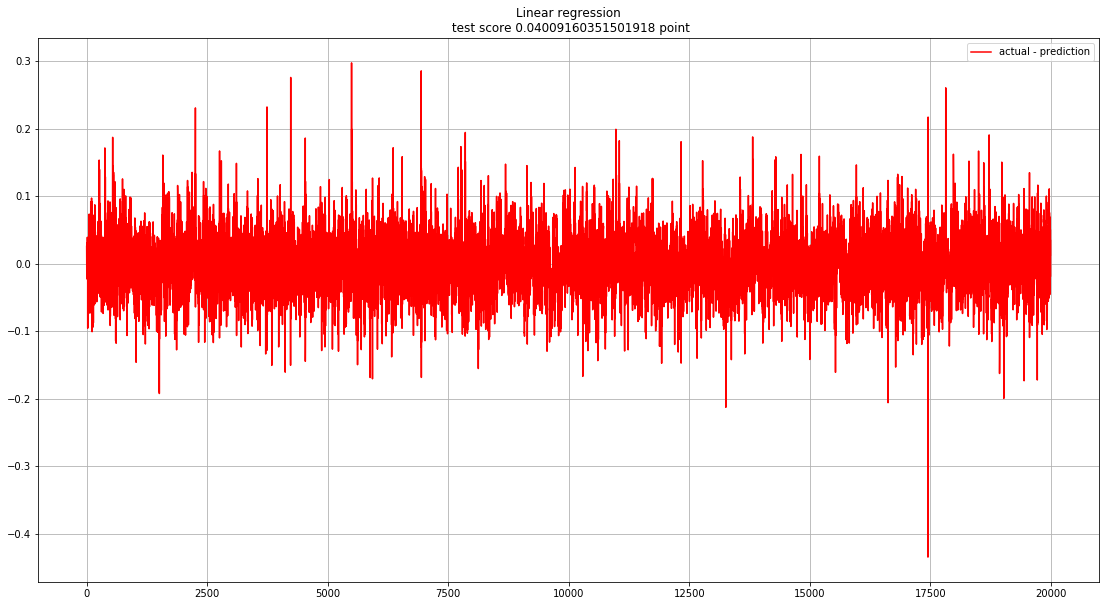

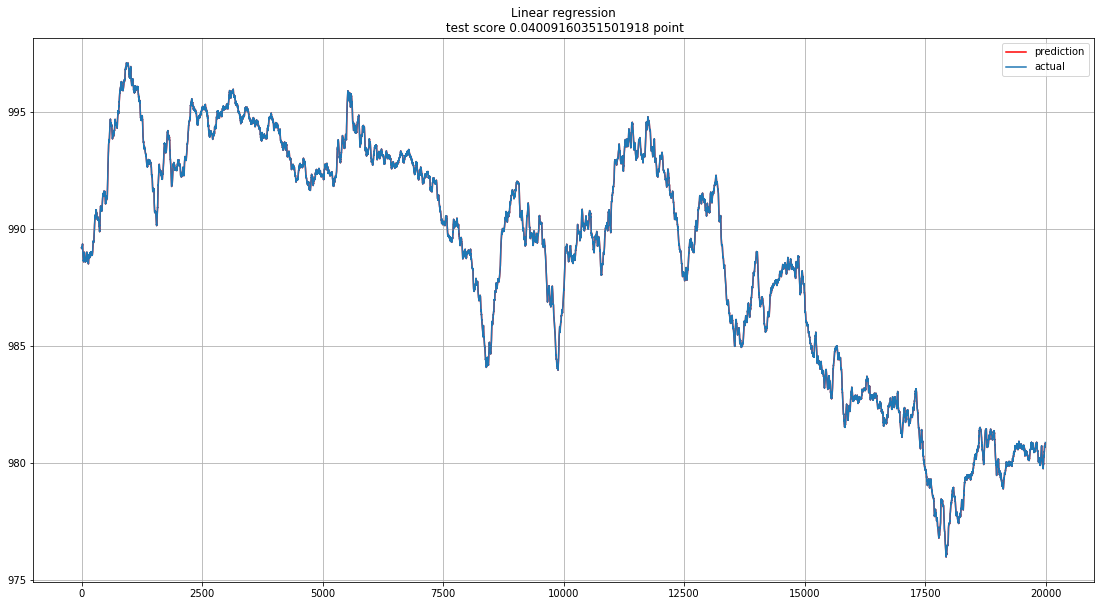

In [78]:
%%time

n_alphas = 100
alphas = np.linspace(-1e-6, 1e-6, n_alphas)

tscv = TimeSeriesSplit(n_splits=10)

X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
X_train, X_test = X_train[top_coef[:45]], X_test[top_coef[:45]]

lr = LassoCV(alphas=alphas, cv=tscv, random_state=17, normalize=True)

lr.fit(X_train.values, y_train.values)
score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('alpha:',lr.alpha_)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head())

alpha: -1e-06
train cv score:	0.03853760551259892
test score:	0.08224292383295118
Значимость коэф.:
          coef_abs
x3_lag_1  1.718105
x3        1.315657
x6_lag_1  1.188057
x6        1.120599
s2_lag_6  0.863043
CPU times: user 2min 10s, sys: 50.7 s, total: 3min 1s
Wall time: 48.6 s


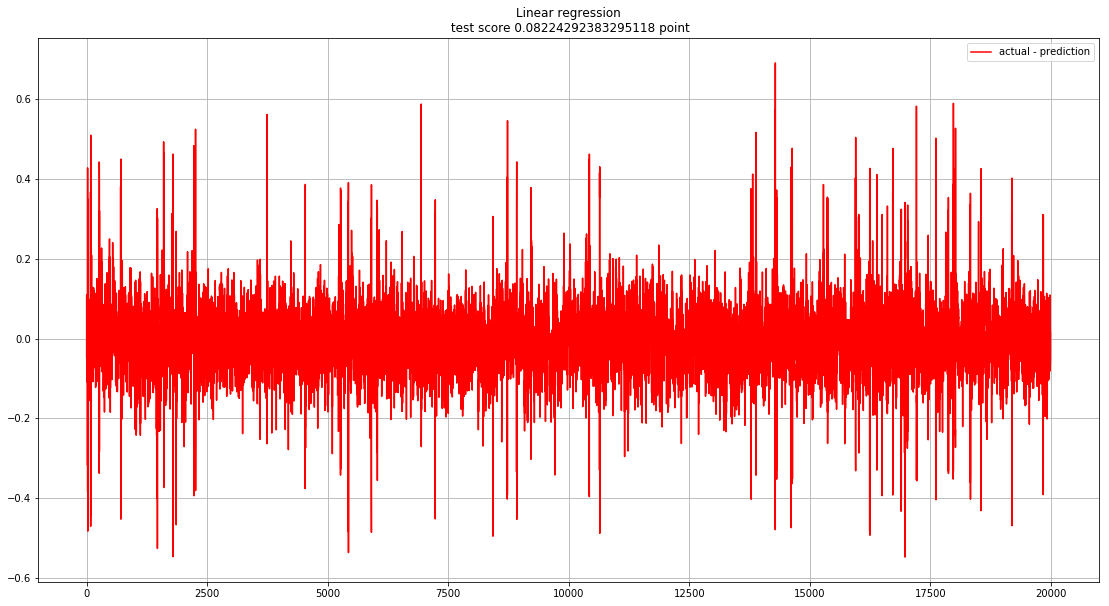

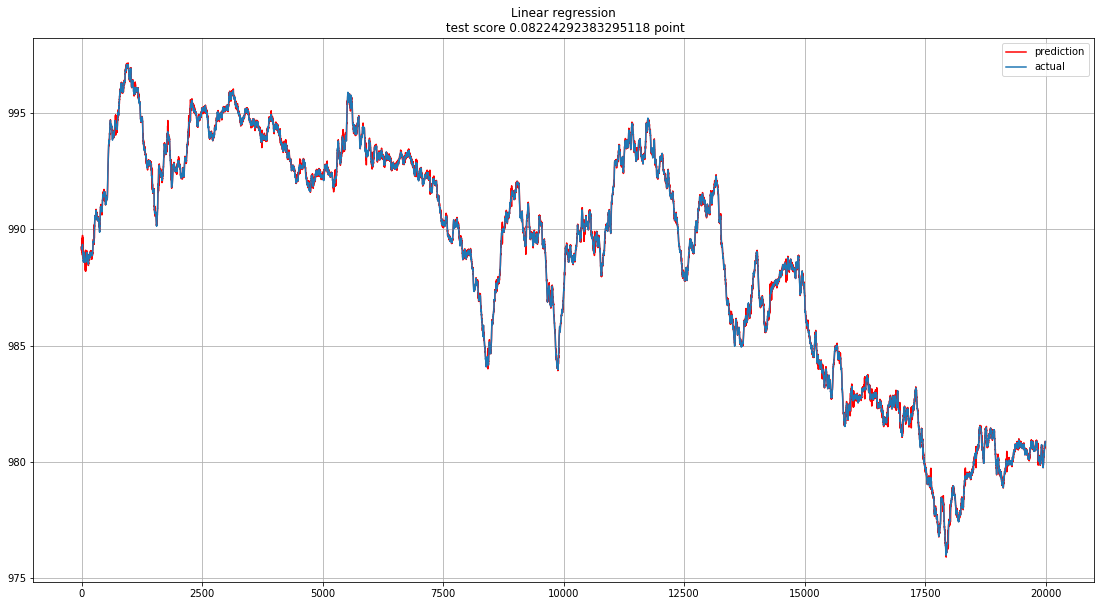

In [79]:
%%time

n_alphas = 10
alphas = np.linspace(-.000001, 0.1, n_alphas)

tscv = TimeSeriesSplit(n_splits=5)

#top_coef1 = top_coef.drop('y1')
X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
#X_train, X_test = X_train[top_coef1[:45]], X_test[top_coef1[:45]]

lr = LassoCV(alphas=alphas, cv=tscv, random_state=17, normalize=True)

lr.fit(X_train.values, y_train.values)
#score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
#                                       cv=tscv, n_jobs=-1, 
#                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('alpha:',lr.alpha_)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head())

alpha: -3.03029454545e-07
train cv score:	0.03853760551259892
test score:	0.05846288050015125
Значимость коэф.:
          coef_abs
x3_lag_1  1.285623
x3        1.267038
x6_lag_1  0.796199
x6        0.779988
y1        0.660899
x5        0.398917
x5_lag_1  0.398261
s2_lag_1  0.374956
s2        0.370175
y1_lag_1  0.342661
CPU times: user 21.6 s, sys: 8.42 s, total: 30 s
Wall time: 11.2 s


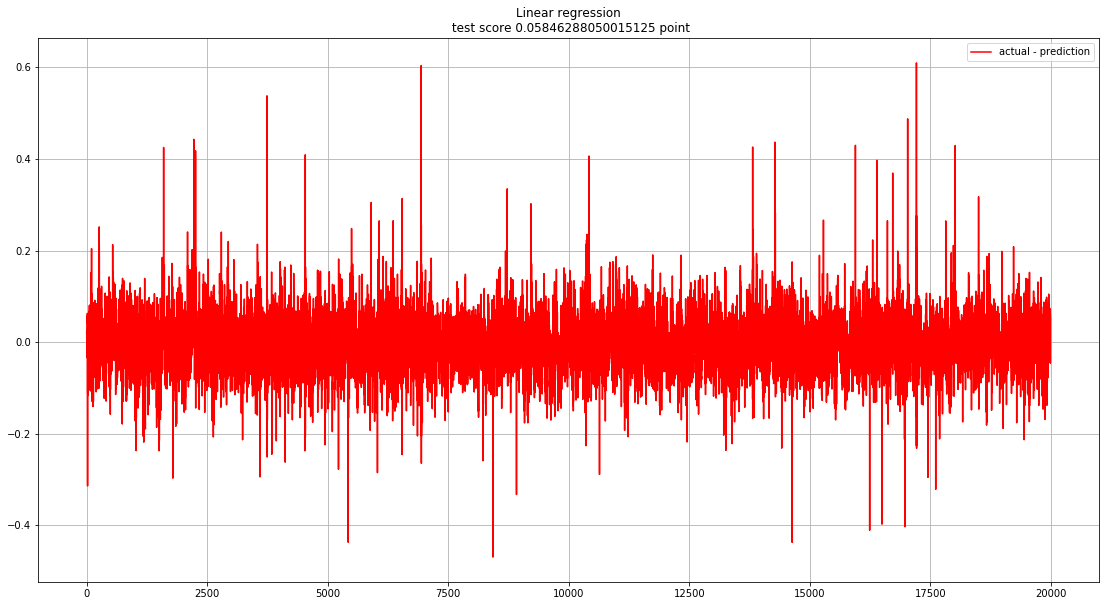

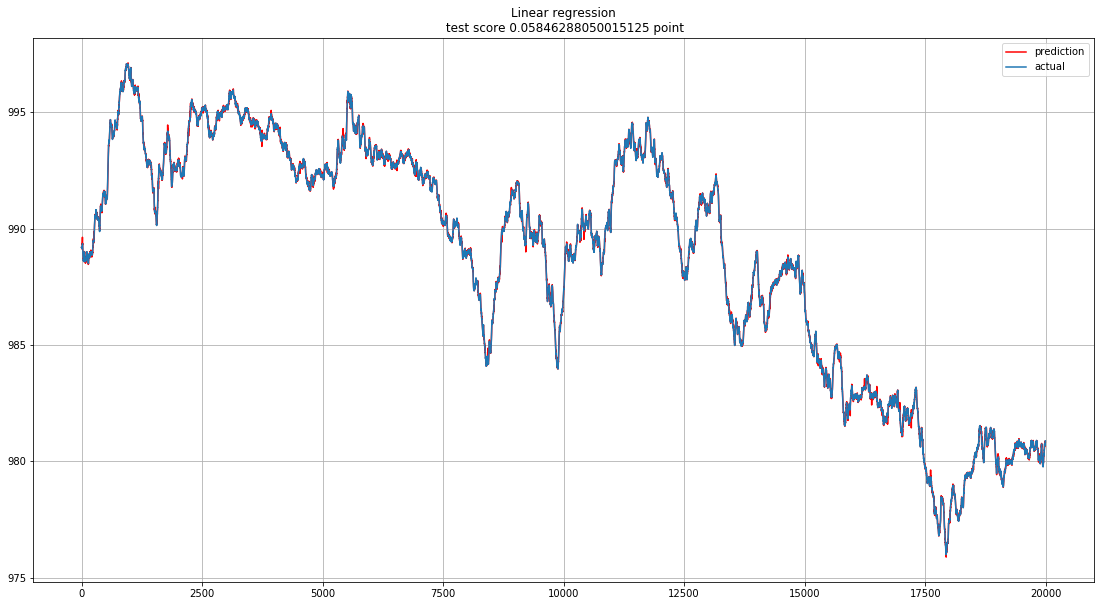

In [80]:
%%time

n_alphas = 100
alphas = np.linspace(-2e-6, 1e-12, n_alphas)

tscv = TimeSeriesSplit(n_splits=5)

#top_coef1 = top_coef.drop('y1')
X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
#X_train, X_test = X_train[top_coef1[:45]], X_test[top_coef1[:45]]

lr = LassoCV(alphas=alphas, cv=tscv, random_state=17, normalize=True)

lr.fit(X_train.values, y_train.values)
#score_cv = np.sqrt(abs(np.mean(cross_val_score(lr, X_train.values, y_train.values, 
#                                       cv=tscv, n_jobs=-1, 
#                                       scoring='neg_mean_squared_error'))))
prediction = lr.predict(X_test.values)
plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('alpha:',lr.alpha_)
print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(lr.coef_, feature_names=X_train.columns).head(10))

train cv score:	2.2766511496536057
test score:	2.714365805285955
Значимость коэф.:
          coef_abs
x6_lag_3  0.150942
x6_lag_4  0.150937
y1        0.102522
y1_lag_1  0.102506
y1_lag_2  0.102484
CPU times: user 1.19 s, sys: 676 ms, total: 1.87 s
Wall time: 3.93 s


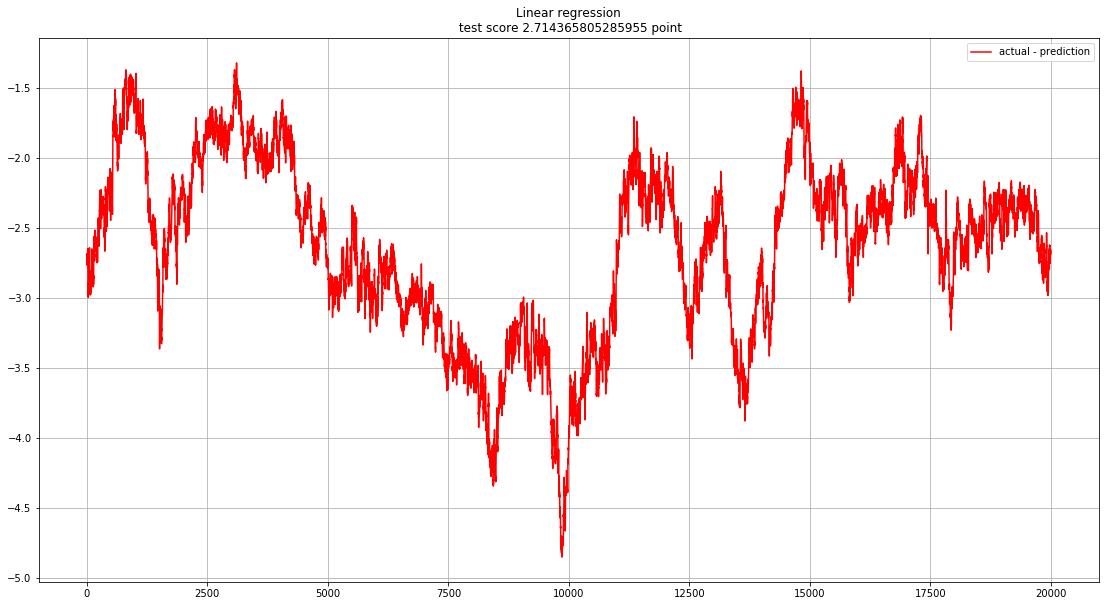

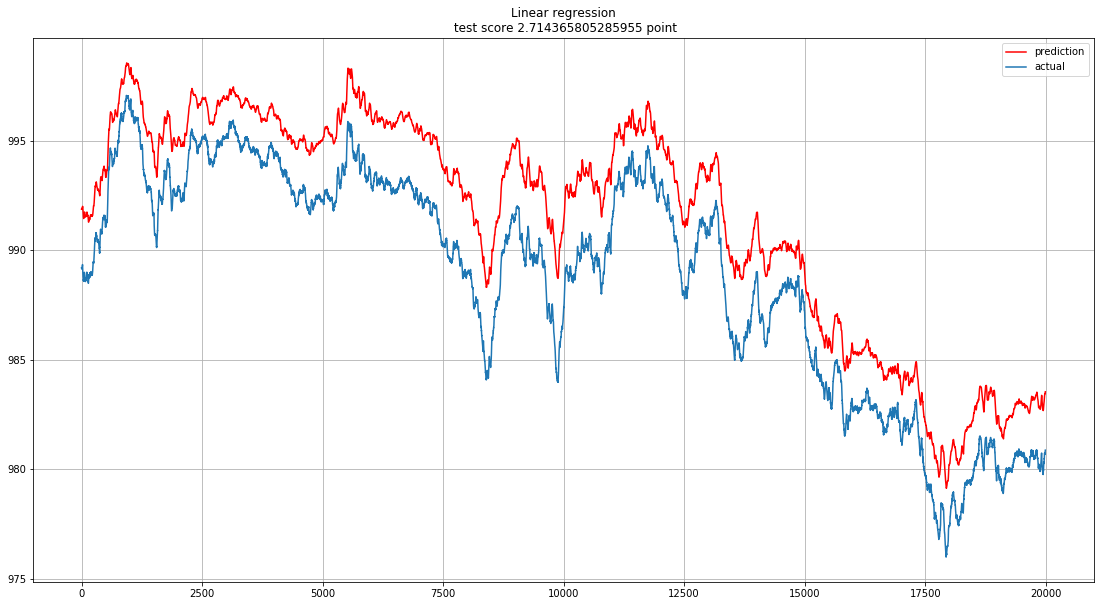

In [81]:
%%time
tscv = TimeSeriesSplit(n_splits=10)

X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
X_train, X_test = X_train[top_coef[:45]], X_test[top_coef[:45]]

ridge = Ridge(random_state=17, normalize=True)

ridge.fit(X_train.values, y_train.values)
score_cv = np.sqrt(abs(np.mean(cross_val_score(ridge, X_train.values, y_train.values, 
                                       cv=tscv, n_jobs=-1, 
                                       scoring='neg_mean_squared_error'))))

prediction = ridge.predict(X_test.values)

plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)

print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(ridge.coef_, feature_names=X_train.columns).head())

alpha 1.66666666667e-16
test score:	0.02239224582121206
Значимость коэф.:
          coef_abs
y1        0.795135
y1_lag_1  0.654944
x5        0.513650
x1        0.494358
x3        0.494330
x2        0.478286
x4        0.467378
x5_lag_1  0.412545
x3_lag_1  0.391984
x1_lag_1  0.384922
x2_lag_1  0.383627
x4_lag_1  0.369128
x5_lag_2  0.336101
x1_lag_2  0.329487
x3_lag_2  0.323247
x2_lag_2  0.310008
x4_lag_2  0.309087
y1_lag_2  0.300659
x5_lag_3  0.154743
x2_lag_3  0.149867
CPU times: user 7min 28s, sys: 6min 40s, total: 14min 9s
Wall time: 6min 39s


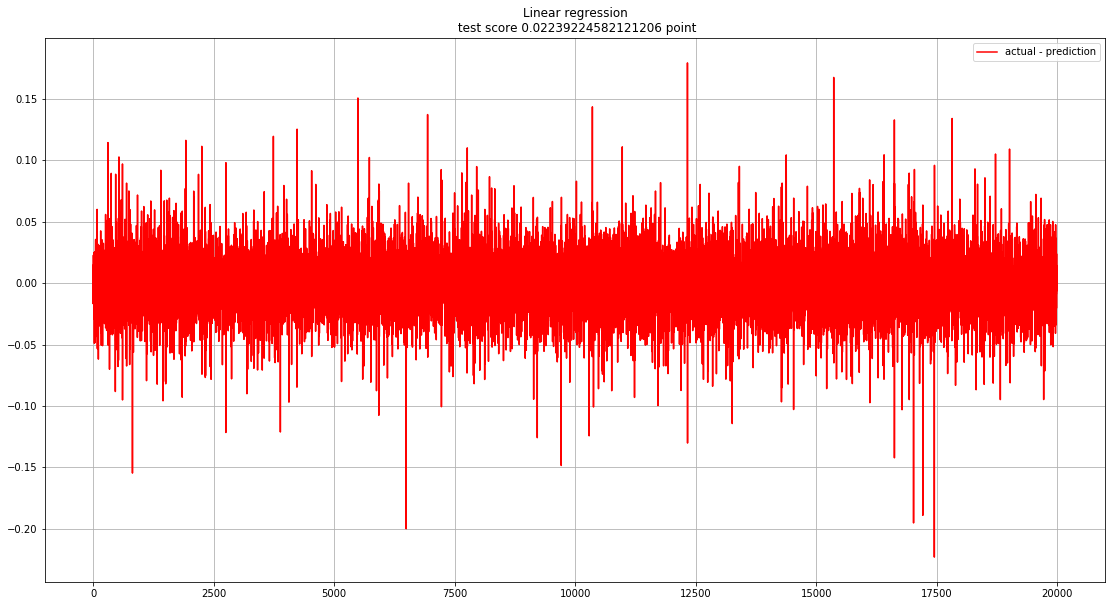

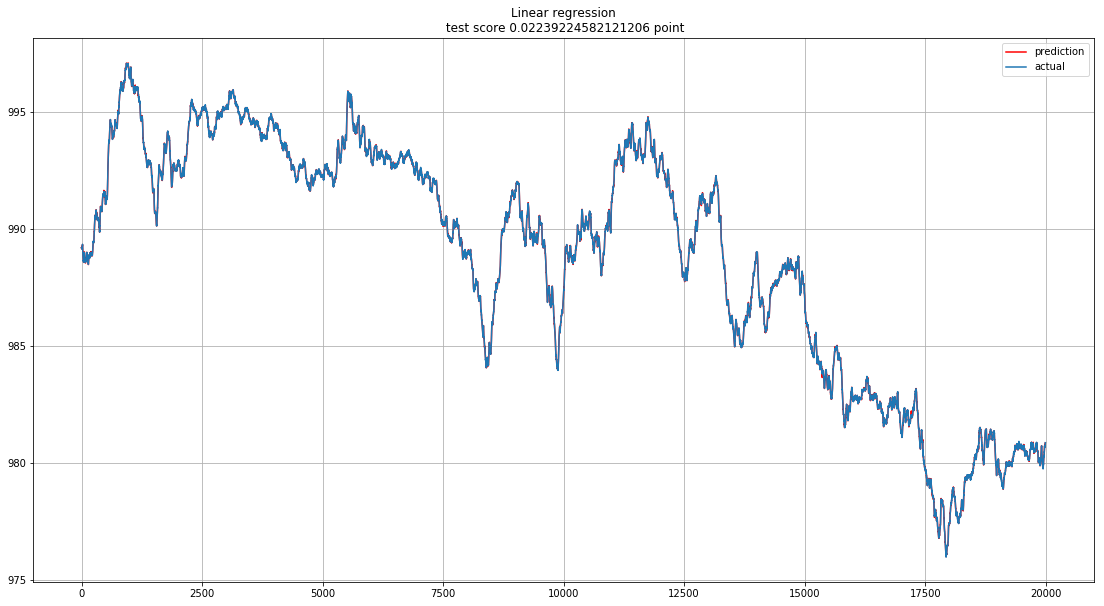

In [82]:
%%time
tscv = TimeSeriesSplit(n_splits=10)

n_alphas = 100
alphas = np.linspace(1e-16, 2e-16, n_alphas)

X_train, X_test, y_train, y_test = prepareData(df, columns_= df.columns[:-1], test_size=0.1,\
                                                       lag_start=1, lag_end=8, print_=False)
#X_train, X_test = X_train[top_coef[:45]], X_test[top_coef[:45]]

ridge = RidgeCV(alphas,normalize=True,cv=tscv)

ridge.fit(X_train.values, y_train.values)
#score_cv = np.sqrt(abs(np.mean(cross_val_score(ridge, X_train.values, y_train.values, 
#                                       cv=tscv, n_jobs=-1, 
#                                       scoring='neg_mean_squared_error'))))

prediction = ridge.predict(X_test.values)

plot_prediction_Linear_regression(y_test,prediction)
plot_prediction_Linear_regression_p(y_test,prediction)
print('alpha',ridge.alpha_)
#print('train cv score:\t{}'.format(score_cv))
print('test score:\t{}'.format(rmse(y_test.values,prediction)))
print('Значимость коэф.:')
print(beatiful_coef(ridge.coef_, feature_names=X_train.columns).head(20)) 

** После не очень приятной ситуации с Losso, с ridge, получилось на удивление очнеь даже годно.**

score: 0.02239224582121206

In [83]:
0.02239224582121206 - 0.02238670617958793

5.539641624127678e-06

In [84]:
RidgeCV?